## Table of Contents
<ul>
<li><a href="#load">Step 0: Load the Data</a></li>
<li><a href="#process">Step 1: Preprocessing</a></li>
<li><a href="#feat_trans">Step 2: Feature Transformation</a></li>
<li><a href="#cluster">Step 3: Clustering</a></li>  
<li><a href="#end">End of Notebook</a></li>  
</ul>

# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from time import time
import ast

# magic word for producing visualizations in notebook
%matplotlib inline

'''
Import note: The classroom currently uses sklearn version 0.19.
If you need to use an imputer, it is available in sklearn.preprocessing.Imputer,
instead of sklearn.impute as in newer versions of sklearn.
'''
from sklearn.impute import SimpleImputer

In [2]:
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 200)

https://stackoverflow.com/questions/18689823/pandas-dataframe-replace-nan-values-with-average-of-columns

>In statistics, imputation is the process of replacing missing data with substituted values. When substituting for a data point, it is known as "unit imputation"; when substituting for a component of a data point, it is known as "item imputation". 

---

<a id='load'></a>
### Step 0: Load the Data
<ul>
<li><a href="#load"><b>Step 0: Load the Data</b></a></li>
<li><a href="#process">Step 1: Preprocessing</a></li>
<li><a href="#feat_trans">Step 2: Feature Transformation</a></li>
<li><a href="#cluster">Step 3: Clustering</a></li>  
<li><a href="#end">End of Notebook</a></li>  
</ul>

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns
<br>
<br>
- Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with **similar demographic properties**. 
- Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

>ParserError: Error tokenizing data. C error: Expected 2 fields in line 3, saw 3 <br>
>https://stackoverflow.com/questions/18039057/python-pandas-error-tokenizing-data <br>
> , error_bad_lines=False | on_bad_lines='skip'

In [3]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep=';')

In [4]:
# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', delimiter=';')

In [5]:
azdias.dtypes.value_counts()

float64    49
int64      32
object      4
dtype: int64

In [6]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).

print(azdias.shape)
azdias.head(20).T

(891221, 85)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
AGER_TYP,-1,-1,-1,2,-1,3,-1,-1,-1,-1,0,-1,-1,-1,-1,1,-1,-1,-1,-1
ALTERSKATEGORIE_GROB,2,1,3,4,3,1,2,1,3,3,3,2,3,1,3,4,1,2,2,3
ANREDE_KZ,1,2,2,2,1,2,2,1,1,2,2,1,1,2,1,2,2,1,2,1
CJT_GESAMTTYP,2.0,5.0,3.0,2.0,5.0,2.0,5.0,3.0,3.0,4.0,1.0,6.0,6.0,5.0,6.0,4.0,1.0,6.0,6.0,3.0
FINANZ_MINIMALIST,3,1,1,4,4,3,1,3,4,2,2,3,5,1,3,4,4,3,2,5
FINANZ_SPARER,4,5,4,2,3,1,5,3,4,4,2,4,3,4,4,1,3,4,4,2
FINANZ_VORSORGER,3,2,1,5,4,5,1,4,2,2,5,3,4,3,3,5,1,3,1,3
FINANZ_ANLEGER,5,5,2,2,1,2,5,1,4,3,3,5,2,5,5,1,4,5,5,1
FINANZ_UNAUFFAELLIGER,5,4,3,1,3,2,4,3,2,5,1,5,4,5,5,1,5,5,4,3
FINANZ_HAUSBAUER,3,5,5,2,2,5,3,2,2,4,5,3,1,2,3,4,1,3,1,1


<br>

In [7]:
azdias.describe().T

,count,mean,std,min,25%,50%,75%,max
AGER_TYP,891221.0,-0.358435,1.198724,-1.0,-1.0,-1.0,-1.0,3.0
ALTERSKATEGORIE_GROB,891221.0,2.777398,1.068775,1.0,2.0,3.0,4.0,9.0
ANREDE_KZ,891221.0,1.522098,0.499512,1.0,1.0,2.0,2.0,2.0
CJT_GESAMTTYP,886367.0,3.632838,1.595021,1.0,2.0,4.0,5.0,6.0
FINANZ_MINIMALIST,891221.0,3.074528,1.321055,1.0,2.0,3.0,4.0,5.0
FINANZ_SPARER,891221.0,2.821039,1.464749,1.0,1.0,3.0,4.0,5.0
FINANZ_VORSORGER,891221.0,3.401106,1.322134,1.0,3.0,3.0,5.0,5.0
FINANZ_ANLEGER,891221.0,3.033328,1.529603,1.0,2.0,3.0,5.0,5.0
FINANZ_UNAUFFAELLIGER,891221.0,2.874167,1.486731,1.0,2.0,3.0,4.0,5.0
FINANZ_HAUSBAUER,891221.0,3.075121,1.353248,1.0,2.0,3.0,4.0,5.0


<br>

In [8]:
print(feat_info.shape)
feat_info

(85, 4)


,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]
5,FINANZ_SPARER,person,ordinal,[-1]
6,FINANZ_VORSORGER,person,ordinal,[-1]
7,FINANZ_ANLEGER,person,ordinal,[-1]
8,FINANZ_UNAUFFAELLIGER,person,ordinal,[-1]
9,FINANZ_HAUSBAUER,person,ordinal,[-1]


In [9]:
feat_info.information_level.value_counts()

person            43
macrocell_plz8     8
household          7
building           7
microcell_rr3      6
region_rr1         5
microcell_rr4      3
postcode           3
community          3
Name: information_level, dtype: int64

In [10]:
feat_info.type.value_counts()

ordinal        49
categorical    21
numeric         7
mixed           7
interval        1
Name: type, dtype: int64

In [11]:
feat_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85 entries, 0 to 84
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   attribute           85 non-null     object
 1   information_level   85 non-null     object
 2   type                85 non-null     object
 3   missing_or_unknown  85 non-null     object
dtypes: object(4)
memory usage: 2.8+ KB


#### Exploring Categorical Columns

In [12]:
# Categorical Columns
cat_col = []
for i in azdias.columns[azdias.isnull().any(axis=0)]:  
    if azdias[i].dtype == 'object':
        cat_col.append(i)

for i in cat_col:
    print(f'Value Counts of {i}:')
    print(azdias[i].value_counts())
    print('\n')

Value Counts of OST_WEST_KZ:
W    629528
O    168545
Name: OST_WEST_KZ, dtype: int64


Value Counts of CAMEO_DEUG_2015:
8    134441
9    108177
6    105874
4    103912
3     86779
2     83231
7     77933
5     55310
1     36212
X       373
Name: CAMEO_DEUG_2015, dtype: int64


Value Counts of CAMEO_DEU_2015:
6B    56672
8A    52438
4C    47819
2D    35074
3C    34769
7A    34399
3D    34307
8B    33434
4A    33155
8C    30993
9D    28593
9B    27676
9C    24987
7B    24503
9A    20542
2C    19422
8D    17576
6E    16107
2B    15486
5D    14943
6C    14820
2A    13249
5A    12214
1D    11909
1A    10850
3A    10543
5B    10354
5C     9935
7C     9065
4B     9047
4D     8570
3B     7160
6A     6810
9E     6379
6D     6073
6F     5392
7D     5333
4E     5321
1E     5065
7E     4633
1C     4317
5F     4283
1B     4071
5E     3581
XX      373
Name: CAMEO_DEU_2015, dtype: int64


Value Counts of CAMEO_INTL_2015:
51    133694
41     92336
24     91158
14     62884
43     56672
54     45391
25

> **Note:** 
“CAMEO_DEUG_2015” and “CAMEO_INTL_2015” are numerical with “X” and “XX” values 
- CAMEO_DEUG_2015 values are all numeric except for X --> 373 
- CAMEO_DEU_2015 & CAMEO_INTL_2015 have the same XX count as CAMEO_DEUG_2015 --> 373
- X and XX may refer to unknown values

<br>

***

> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 
<a id='process'></a>
## Step 1: Preprocessing
<ul>
<li><a href="#load">Step 0: Load the Data</a></li>
<li><a href="#process"><b>Step 1: Preprocessing</b></a></li>
<li><a href="#feat_trans">Step 2: Feature Transformation</a></li>
<li><a href="#cluster">Step 3: Clustering</a></li>  
<li><a href="#end">End of Notebook</a></li>  
</ul>

<a id='assess'></a>
### Step 1.1: Assess Missing Data
<ul>
<li><a href="#assess"><b>Step 1.1: Assess Missing Data</b></a></li>
<li><a href="#encode">Step 1.2: Select and Re-Encode Features</a></li>
<li><a href="#clean_func">Step 1.3: Create a Cleaning Function</a></li>
</ul>

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

<a id='missing_to_nans'></a>
#### Step 1.1.1: Convert Missing Value Codes to NaNs
<ul>
<li><a href="#missing_to_nans"><b>Step 1.1.1: Convert Missing Value Codes to NaNs</b></a></li>
<li><a href="#assess_missing_col">Step 1.1.2: Assess Missing Data in Each Column</a></li>
<li><a href="#assess_missing_row">Step 1.1.3: Assess Missing Data in Each Row</a></li>
</ul>

The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. 

- You'll need to do a little bit of parsing to make use of it to identify and clean the data. 
- Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. 
- You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [13]:
# Identify missing or unknown data values and convert them to NaNs.


In [14]:
print(f'Number of naturally missing values is: {azdias.isnull().sum().sum()}')

Number of naturally missing values is: 4896838


In [15]:
# feat_info.missing_or_unknown.value_counts()

In [16]:
# feat_info['missing_or_unknown'][0]

In [17]:
# feat_info['missing_or_unknown'][0][1:-1]

In [18]:
# feat_info['missing_or_unknown'][0][1:-1].split(",")

https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.replace.html <br>
https://stackoverflow.com/questions/1841565/valueerror-invalid-literal-for-int-with-base-10

<br>

**The Fastest Method Till now**

In [19]:
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep=';')

In [20]:
def convert_missing_to_nans(df):
    missing_list = []
    for ls in feat_info['missing_or_unknown']:
    # values[1:-1] --> removes the square brackets from the list as it's encoded as a string
        missing = ls[1:-1].split(",")
        missing = [int(float(value)) if (value!='X' and value!='XX' and value!='') else value for value in missing]
        missing_list.append(missing)
    
    for attribute, missing_values in zip(feat_info["attribute"],missing_list):
        df[attribute] = df[attribute].replace(missing_values, np.nan)
    return df

In [21]:
t0 = time()
convert_missing_to_nans(azdias)
print(time()-t0)

1.6130249500274658


In [22]:
print(f'Total Number of missing values is: {azdias.isnull().sum().sum()}')

Total Number of missing values is: 8373929


<br>

#### Method 1

In [23]:
# azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep=';')

In [24]:
# t0 = time()
# missing_list = []
# for ls in feat_info['missing_or_unknown']:
#     # values[1:-1] --> removes the square brackets
#     missing = ls[1:-1].split(",")
#     missing = [int(float(value)) if (value!='X' and value!='XX' and value!='') else value for value in missing]
#     missing_list.append(missing)
    
# for idx in range(len(feat_info)):
#     azdias = azdias.replace({feat_info.iloc[idx]['attribute']: missing_list[idx]}, np.nan)

# print(time()-t0)

In [25]:
# print(f'Total Number of missing values is: {azdias.isnull().sum().sum()}')

<br>

In [26]:
# azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep=';')

In [27]:
# t0 = time()

# for idx in range(len(feat_info)):
#     missing = feat_info.iloc[idx]['missing_or_unknown']
#     missing = missing.strip('[').strip(']').split(sep=',')
#     missing = [int(value) if (value!='X' and value!='XX' and value!='') else value for value in missing]
#     if missing != ['']:
#         azdias = azdias.replace({feat_info.iloc[idx]['attribute']: missing}, np.nan)
        
# print(time()-t0)

In [28]:
# print(f'Total Number of missing values is: {azdias.isnull().sum().sum()}')

#### Method 2

In [29]:
# azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep=';')

In [30]:
# missing_list = []
# for ls in feat_info['missing_or_unknown']:
#     # values[1:-1] --> removes the square brackets
#     missing = ls[1:-1].split(",")
#     missing_list.append(missing)

In [31]:
# # Faster Approach
# def convert_missing_to_nans(df):
#     # Identify missing or unknown data values and convert them to NaNs.
#     for attribute, missing_values in zip(feat_info["attribute"],missing_list):
#         if missing_values[0] != "": # if the list not empty 
#             for value in missing_values:
#                 #check if the missing value is number (negative or positive numbers)
#                 # or value.lstrip('-').isnumeric() --> for negative values
#                 if value.isnumeric() or value.lstrip('-').isnumeric():
#                     value = int(value)
            
#                 df.loc[df[attribute] == value, attribute] = np.nan

In [32]:
# t0 = time()
# convert_missing_to_nans(azdias)
# print(time()-t0)

In [33]:
# print(f'Total Number of missing values is: {azdias.isnull().sum().sum()}')

<br>

In [34]:
# azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep=';')

In [35]:
# missing_list = []
# for ls in feat_info['missing_or_unknown']:
#     # values[1:-1] --> removes the square brackets
#     missing = ls[1:-1].split(",")
#     missing_list.append(missing)

In [36]:
# # Way Faster Approach
# def convert_missing_to_nans(df):
#     # Identify missing or unknown data values and convert them to NaNs.
#     for attribute, missing_values in zip(feat_info["attribute"],missing_list):
#         if missing_values[0] != "": # if the list not empty 
#             for value in missing_values:
#                 #check if the missing value is number (negative or positive numbers)
#                 # or value.lstrip('-').isnumeric() --> for negative values
#                 if value.isnumeric() or value.lstrip('-').isnumeric():
#                     value = int(value)
            
# #                 df.loc[df[attribute] == value, attribute] = np.nan
#                 df[attribute] = df[attribute].replace({value: np.nan})

In [37]:
# t0 = time()
# convert_missing_to_nans(azdias)
# print(time()-t0)

In [38]:
# print(f'Total Number of missing values is: {azdias.isnull().sum().sum()}')

<br>

####  Another Method
- we  could remove X and XX
- then use literal_eval to convert str to list of numbers
- then we could replace them with NaNs

In [39]:
# ast.literal_eval("[-1, XX]") --> Raises Error

In [40]:
# ast.literal_eval("[-1, 0]")

In [41]:
# ast.literal_eval('[]')

In [42]:
# feat_info['missing_or_unknown'] = feat_info['missing_or_unknown'].str.replace("X", "")
# feat_info.missing_or_unknown.value_counts()

In [43]:
# ast.literal_eval("[-1,]") 

In [44]:
# # Pandas DataFrame stored list as string: Convert back to list
# missing_list = feat_info['missing_or_unknown'].apply(lambda x: ast.literal_eval(str(x))) 

<br>

<a id='assess_missing_col'></a>
#### Step 1.1.2: Assess Missing Data in Each Column
<ul>
<li><a href="#missing_to_nans">Step 1.1.1: Convert Missing Value Codes to NaNs</a></li>
<li><a href="#assess_missing_col"><b>Step 1.1.2: Assess Missing Data in Each Column</b></a></li>
<li><a href="#assess_missing_row">Step 1.1.3: Assess Missing Data in Each Row</a></li>
</ul>

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

<br>

<br>

In [45]:
# Perform an assessment of how much missing data there is in each column of the dataset.

In [46]:
# missing = azdias.isnull().sum()[azdias.isnull().sum() > 0].to_frame().reset_index()
# missing.columns = ['attribute', 'missing_count']
# missing['percent'] = np.round(missing['missing_count'] / azdias.shape[0] * 100, 2) 
# missing.sort_values(by='percent', ascending=False, inplace=True)
# missing.head(60)

In [47]:
# Missing Values Count and percent % in each column

missing_count = azdias.isnull().sum() # [azdias.isnull().sum() > 0]
dic_nan = {'sum_nans': missing_count.values, 
           'percent': np.round(missing_count.values * 100 / azdias.shape[0], 2)}

azdias_nan = pd.DataFrame(data=dic_nan, index=missing_count.index)
# Sort by percentage
azdias_nan.sort_values(by='percent', ascending=False, inplace=True)
azdias_nan.head(10)

,sum_nans,percent
TITEL_KZ,889061,99.76
AGER_TYP,685843,76.96
KK_KUNDENTYP,584612,65.60
KBA05_BAUMAX,476524,53.47
GEBURTSJAHR,392318,44.02
ALTER_HH,310267,34.81
KKK,158064,17.74
REGIOTYP,158064,17.74
W_KEIT_KIND_HH,147988,16.61
KBA05_ANTG1,133324,14.96


In [48]:
feat_info.head()

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


In [49]:
feat_info.set_index('attribute', inplace=True, drop=False)

# Merge with the feat_info dataframe
feat_info = feat_info.join(azdias_nan)
feat_info.sort_values(by='percent', ascending=False, inplace=True)
feat_info.head()

,attribute,information_level,type,missing_or_unknown,sum_nans,percent
attribute,,,,,,
TITEL_KZ,TITEL_KZ,person,categorical,"[-1,0]",889061,99.76
AGER_TYP,AGER_TYP,person,categorical,"[-1,0]",685843,76.96
KK_KUNDENTYP,KK_KUNDENTYP,household,categorical,[-1],584612,65.60
KBA05_BAUMAX,KBA05_BAUMAX,microcell_rr3,mixed,"[-1,0]",476524,53.47
GEBURTSJAHR,GEBURTSJAHR,person,numeric,[0],392318,44.02


In [50]:
# Investigate patterns in the amount of missing data in each column.

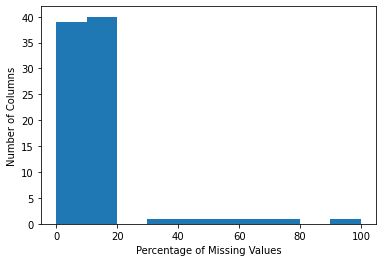

In [51]:
plt.hist(azdias_nan['percent'])
plt.ylabel('Number of Columns')
plt.xlabel('Percentage of Missing Values')
plt.show()

https://matplotlib.org/3.5.0/gallery/color/named_colors.html

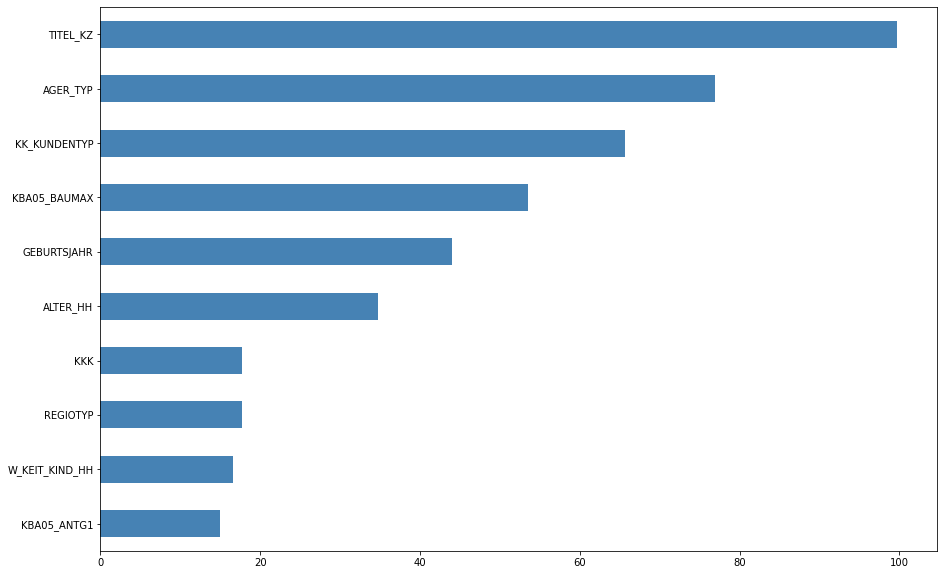

In [52]:
azdias_nan.percent.head(10).plot.barh(figsize=(15, 10), color = 'steelblue');
plt.gca().invert_yaxis()

>### TITEL_KZ --> 99.76% Missing Values
>Academic title flag
- -1: unknown
-  0: unknown
-  1: Dr.
-  2: Dr. Dr.
-  3: Prof.
-  4: Prof. Dr.
-  5: other

In [53]:
azdias['TITEL_KZ'].value_counts()

1.0    1947
5.0     104
4.0      57
3.0      49
2.0       3
Name: TITEL_KZ, dtype: int64

>### AGER_TYP --> 76.96% Missing Values
Person-level features <br>
Best-ager typology
- -1: unknown
-  0: no classification possible
-  1: passive elderly
-  2: cultural elderly
-  3: experience-driven elderly

>### KK_KUNDENTYP --> 65.60% Missing Values
Household-level features <br>
Consumer pattern over past 12 months
- -1: unknown
-  1: regular customer
-  2: active customer
-  3: new costumer
-  4: stray customer
-  5: inactive customer
-  6: passive customer

>### KBA05_BAUMAX --> 53.47% Missing Values
RR3 micro-cell features <br>
Most common building type within the microcell
- -1: unknown
-  0: unknown
-  1: mainly 1-2 family homes in the microcell
-  2: mainly 3-5 family homes in the microcell
-  3: mainly 6-10 family homes in the microcell
-  4: mainly 10+ family homes in the microcell
-  5: mainly business buildings in the microcell

>### GEBURTSJAHR --> 44.02% Missing Values
Person-level features <br>
Year of birth
- missing data encoded as 0

>### ALTER_HH --> 34.81% Missing Values
Household-level features <br>
Birthdate of head of household
-  0: unknown / no main age detectable
-  1: 1895-01-01 to 1899-12-31
-  2: 1900-01-01 to 1904-12-31
-  3: 1905-01-01 to 1909-12-31
-  4: 1910-01-01 to 1914-12-31
-  5: 1915-01-01 to 1919-12-31
-  6: 1920-01-01 to 1924-12-31
-  7: 1925-01-01 to 1929-12-31
-  8: 1930-01-01 to 1934-12-31
-  9: 1935-01-01 to 1939-12-31
- 10: 1940-01-01 to 1944-12-31
- 11: 1945-01-01 to 1949-12-31
- 12: 1950-01-01 to 1954-12-31
- 13: 1955-01-01 to 1959-12-31
- 14: 1960-01-01 to 1964-12-31
- 15: 1965-01-01 to 1969-12-31
- 16: 1970-01-01 to 1974-12-31
- 17: 1975-01-01 to 1979-12-31
- 18: 1980-01-01 to 1984-12-31
- 19: 1985-01-01 to 1989-12-31
- 20: 1990-01-01 to 1994-12-31
- 21: 1995-01-01 to 1999-12-31

<br>

In [54]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)

In [55]:
# Remove columns with more than 20% missing values
# thresh --> Require that many non-NA values.
print(azdias.shape)

limit = len(azdias) * 0.8
azdias.dropna(thresh=limit, axis=1, inplace=True)
print(azdias.shape)
azdias.head(1)

(891221, 85)
(891221, 79)


,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,VERS_TYP,ZABEOTYP,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_DEUG_2015,CAMEO_DEU_2015,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2.0,1,2.0,3,4,3,5,5,3,4,10.0,0,NaN,15.0,4.0,2.0,2.0,1.0,1.0,NaN,NaN,5.0,2,6,7,5,1,5,3,3,4,7,6,6,5,3,NaN,NaN,NaN,3,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [56]:
# azdias[['CAMEO_DEUG_2015', 'CAMEO_INTL_2015']].info()
azdias.dtypes.value_counts()

float64    51
int64      24
object      4
dtype: int64

In [57]:
# azdias_o['CAMEO_DEUG_2015'].value_counts()

In [58]:
# azdias_o['CAMEO_DEUG_2015'].dtype == 'object'

In [59]:
# azdias_o.select_dtypes(include=['object']).columns

In [60]:
# for col in azdias_o.select_dtypes(include=['object']).columns:
#     try:
#         azdias_o[col] = azdias_o[col].astype('float')
#         print(col)
#     except:
#         print('hi')
#         continue

In [61]:
# Convert Categorical columns to float
# azdias[['CAMEO_DEUG_2015', 'CAMEO_INTL_2015']] = azdias[['CAMEO_DEUG_2015', 'CAMEO_INTL_2015']].astype('float')

def convert_to_float(df): 
    for col in df.select_dtypes(include=['object']).columns:
        try:
            df[col] = df[col].astype('float')
        except:
            continue
                
convert_to_float(azdias)
azdias.dtypes.value_counts()

float64    53
int64      24
object      2
dtype: int64

In [62]:
# Categorical Columns --> Are not just columns with strings as we do have mapping to values in some columns
cat_col = []
for i in azdias.columns[azdias.isnull().any(axis=0)]:  
    if azdias[i].dtype == 'object':
        cat_col.append(i)
        
for i in cat_col:
    print(f'Value Counts of {i}:')
    print(azdias[i].value_counts().head())
    print('\n')

Value Counts of OST_WEST_KZ:
W    629528
O    168545
Name: OST_WEST_KZ, dtype: int64


Value Counts of CAMEO_DEU_2015:
6B    56672
8A    52438
4C    47819
2D    35074
3C    34769
Name: CAMEO_DEU_2015, dtype: int64




>### OST_WEST_KZ
Building-level features <br>
Building location via former East / West Germany (GDR / FRG)
- -1: unknown
-  O: East (GDR)
-  W: West (FRG)

>### CAMEO_DEU_2015
RR4 micro-cell features <br>
German CAMEO: Wealth / Life Stage Typology, detailed scale
- 1A: Work-Life-Balance
- 1B: Wealthy Best Ager
- 1C: Successful Songwriter
- 1D: Old Nobility
- 1E: City Nobility
- 2A: Cottage Chic
- 2B: Noble Jogger
- 2C: Established gourmet
- 2D: Fine Management
- 3A: Career & Family
- 3B: Powershopping Families
- 3C: Rural Neighborhood
- 3D: Secure Retirement
- 4A: Family Starter
- 4B: Family Life
- 4C: String Trimmer
- 4D: Empty Nest
- 4E: Golden Ager
- 5A: Younger Employees
- 5B: Suddenly Family
- 5C: Family First
- 5D: Stock Market Junkies
- 5E: Coffee Rider
- 5F: Active Retirement
- 6A: Jobstarter
- 6B: Petty Bourgeois
- 6C: Long-established
- 6D: Sportgardener
- 6E: Urban Parents
- 6F: Frugal Aging
- 7A: Journeymen
- 7B: Mantaplatte
- 7C: Factory Worker
- 7D: Rear Window
- 7E: Interested Retirees
- 8A: Multi-culteral
- 8B: Young & Mobile
- 8C: Prefab
- 8D: Town Seniors
- 9A: First Shared Apartment
- 9B: Temporary Workers
- 9C: Afternoon Talk Show
- 9D: Mini-Jobber
- 9E: Socking Away
- XX: unknown

In [63]:
azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 79 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   ALTERSKATEGORIE_GROB   888340 non-null  float64
 1   ANREDE_KZ              891221 non-null  int64  
 2   CJT_GESAMTTYP          886367 non-null  float64
 3   FINANZ_MINIMALIST      891221 non-null  int64  
 4   FINANZ_SPARER          891221 non-null  int64  
 5   FINANZ_VORSORGER       891221 non-null  int64  
 6   FINANZ_ANLEGER         891221 non-null  int64  
 7   FINANZ_UNAUFFAELLIGER  891221 non-null  int64  
 8   FINANZ_HAUSBAUER       891221 non-null  int64  
 9   FINANZTYP              891221 non-null  int64  
 10  GFK_URLAUBERTYP        886367 non-null  float64
 11  GREEN_AVANTGARDE       891221 non-null  int64  
 12  HEALTH_TYP             780025 non-null  float64
 13  LP_LEBENSPHASE_FEIN    793589 non-null  float64
 14  LP_LEBENSPHASE_GROB    796649 non-nu

<br>

#### Discussion 1.1.2: Assess Missing Data in Each Column

(Double click this cell and replace this text with your own text, reporting your observations regarding the amount of missing data in each column. Are there any patterns in missing values? Which columns were removed from the dataset?)

> We dropped 6 columns with more than 30% missing data

In [64]:
print('\n The Dropped Columns --> with more than 30% NaNs')
feat_info[feat_info.percent > 30]


 The Dropped Columns --> with more than 30% NaNs


,attribute,information_level,type,missing_or_unknown,sum_nans,percent
attribute,,,,,,
TITEL_KZ,TITEL_KZ,person,categorical,"[-1,0]",889061,99.76
AGER_TYP,AGER_TYP,person,categorical,"[-1,0]",685843,76.96
KK_KUNDENTYP,KK_KUNDENTYP,household,categorical,[-1],584612,65.60
KBA05_BAUMAX,KBA05_BAUMAX,microcell_rr3,mixed,"[-1,0]",476524,53.47
GEBURTSJAHR,GEBURTSJAHR,person,numeric,[0],392318,44.02
ALTER_HH,ALTER_HH,household,interval,[0],310267,34.81


In [65]:
# Drop features with more than 30% missing values
feat_info_sub = feat_info[feat_info.percent < 30]

<br>

<a id='assess_missing_row'></a>
#### Step 1.1.3: Assess Missing Data in Each Row
<ul>
<li><a href="#missing_to_nans">Step 1.1.1: Convert Missing Value Codes to NaNs</a></li>
<li><a href="#assess_missing_col">Step 1.1.2: Assess Missing Data in Each Column</a></li>
<li><a href="#assess_missing_row"><b>Step 1.1.3: Assess Missing Data in Each Row</b></a></li>
</ul>

Now, you'll perform a similar assessment for the rows of the dataset. **How much data is missing in each row?** As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [66]:
# How much data is missing in each row of the dataset?

In [67]:
# Add a column with the number of nans in each row 
azdias['n_nans'] = azdias.isnull().sum(axis=1)
azdias.n_nans.describe()

count    891221.000000
mean          5.649894
std          13.234687
min           0.000000
25%           0.000000
50%           0.000000
75%           3.000000
max          49.000000
Name: n_nans, dtype: float64

>- There are 891221 observations (rows) with the mean of 5.36 missing values per row. 

In [68]:
rows_with_nans = (azdias['n_nans'] == 0).sum() * 100 / len(azdias)
print(f'Number of rows with no missing data {(azdias.n_nans == 0).sum()} -->', end =" ")
print('({:0.2f}%).'.format(rows_with_nans))

print(f'Number of rows with missing data {(azdias.n_nans != 0).sum()} -->', end =" ")
print('({:0.2f}%).'.format(100 - rows_with_nans))

Number of rows with no missing data 623209 --> (69.93%).
Number of rows with missing data 268012 --> (30.07%).


> **Note:** We can divide the data into two subsets: 
>- one for rows with no missing values, 
>- and a second subset for rows with missing values.

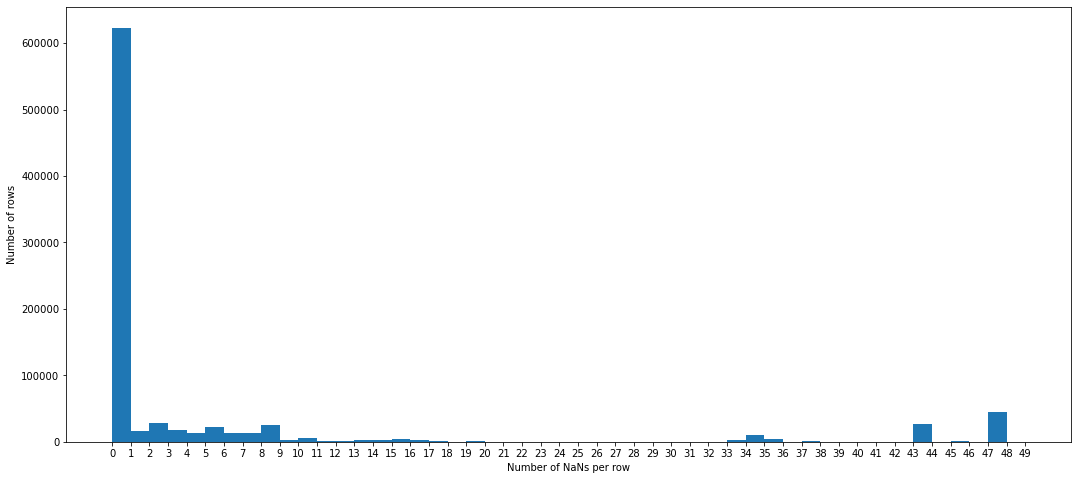

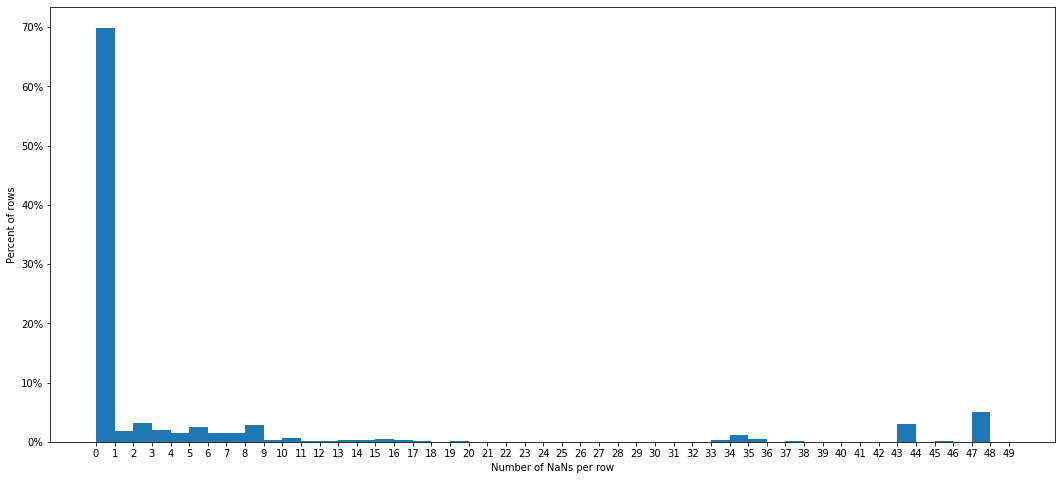

In [69]:
# azdias['n_nans'].value_counts()

plt.figure(figsize=(18, 8))
plt.xticks(np.arange(0, azdias['n_nans'].max()+1, 1))
plt.xlabel('Number of NaNs per row')
plt.ylabel('Number of rows')
# Number of observations in the Y axis
plt.hist(azdias['n_nans'], bins=np.arange(0, azdias['n_nans'].max()+1, 1));
plt.show();


import matplotlib.ticker as mtick
plt.figure(figsize=(18, 8))
plt.xticks(np.arange(0, azdias['n_nans'].max()+1, 1))
plt.xlabel('Number of NaNs per row')
plt.ylabel('Percent of rows')
# Percent of NaNs in the Y axis
# weights --> multiplied by the counts give the percent %
plt.hist(azdias['n_nans'], weights=np.ones(len(azdias)) / len(azdias), bins=np.arange(0, azdias['n_nans'].max()+1, 1))
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))
plt.show();

<br>

In [70]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.

In [71]:
azdias_no_nans = azdias[azdias.n_nans == 0]
azdias_with_nans = azdias[azdias.n_nans != 0]

In [72]:
feat_info.head(1)

,attribute,information_level,type,missing_or_unknown,sum_nans,percent
attribute,,,,,,
TITEL_KZ,TITEL_KZ,person,categorical,"[-1,0]",889061,99.76


In [73]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.

In [74]:
# feat_info.query(" percent == 0 & type == 'ordinal'")

In [75]:
# Select randomly 5 columns for the comparison
np.random.seed(42)
sample_columns = np.random.choice(feat_info.query(" percent == 0 & type == 'ordinal'").attribute , 5).tolist()
sample_columns

['SEMIO_KAEM', 'SEMIO_TRADV', 'SEMIO_ERL', 'SEMIO_REL', 'SEMIO_SOZ']

In [76]:
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

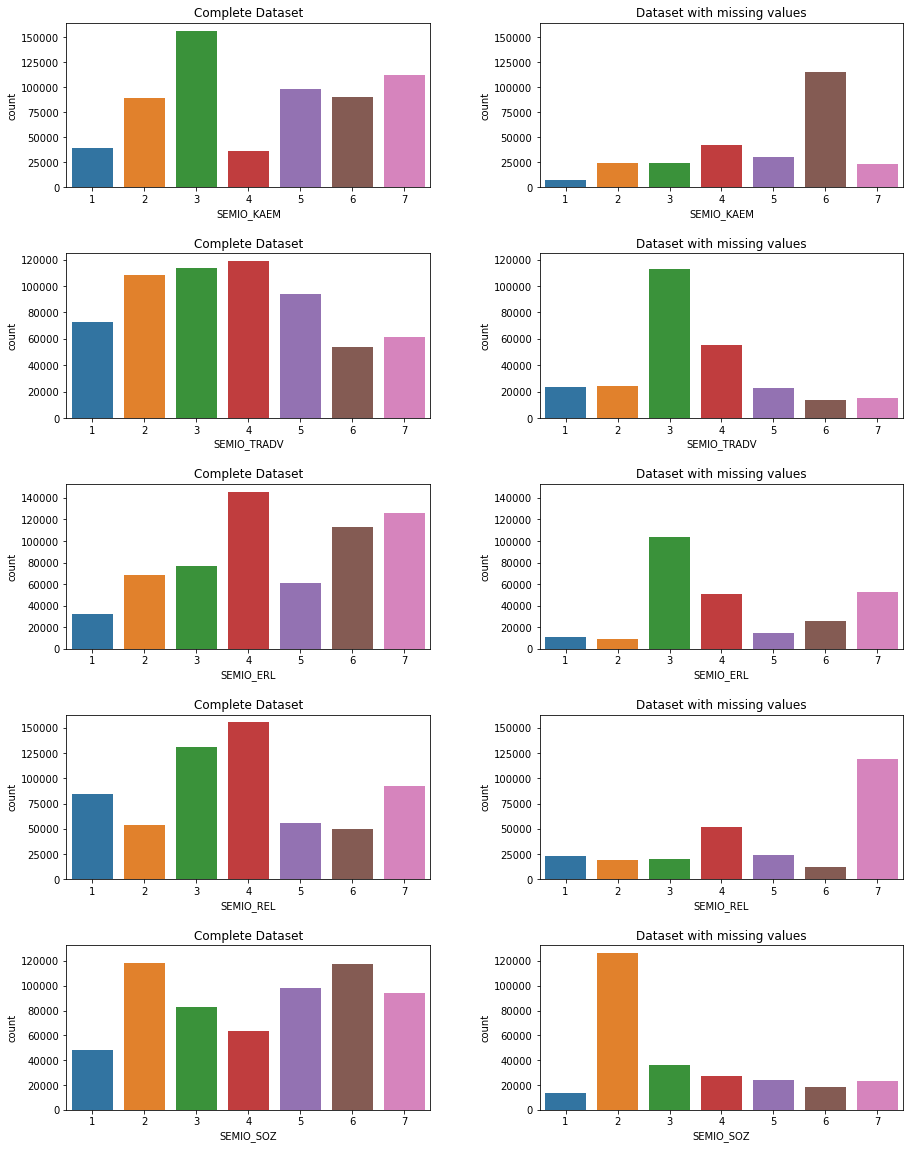

In [77]:
figure, axs = plt.subplots(nrows=len(sample_columns), ncols=2, figsize = (15,20), sharey='row') # sharey=True
figure.subplots_adjust(hspace =.4, wspace=.3)

for i in range(len(sample_columns)):
    sns.countplot(azdias_no_nans[sample_columns[i]], ax=axs[i][0]);
    axs[i][0].set_title('Complete Dataset');
    
    sns.countplot(azdias_with_nans[sample_columns[i]], ax=axs[i][1]);
    axs[i][1].set_title('Dataset with missing values');
    axs[i][1].yaxis.set_tick_params(labelleft=True)

<br>

#### Discussion 1.1.3: Assess Missing Data in Each Row

(Double-click this cell and replace this text with your own text, reporting your observations regarding missing data in rows. Are the data with lots of missing values are qualitatively different from data with few or no missing values?)

> The Distributions for "the Complete" and "the Incomplete" datasets are different.

In [78]:
split_value = 0

In [79]:
# Remove all rows with missing values above split_value
print(azdias.shape)
azdias = azdias[azdias.n_nans <= split_value]
print(azdias.shape)

(891221, 80)
(623209, 80)


In [80]:
# Missing data in the dataset
azdias.isnull().sum(axis=1).sum()

0

***

<a id='encode'></a>
### Step 1.2: Select and Re-Encode Features
<ul>
<li><a href="#assess">Step 1.1: Assess Missing Data</a></li>
<li><a href="#encode"><b>Step 1.2: Select and Re-Encode Features</b></a></li>
<li><a href="#clean_func">Step 1.3: Create a Cleaning Function</a></li>
</ul>

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [81]:
# How many features are there of each data type?

feat_info.type.value_counts()

ordinal        49
categorical    21
mixed           7
numeric         7
interval        1
Name: type, dtype: int64

In [82]:
azdias.dtypes.value_counts()

float64    53
int64      25
object      2
dtype: int64

<br>

<a id='categorical'></a>
#### Step 1.2.1: Re-Encode Categorical Features
<ul>
<li><a href="#categorical"><b>Step 1.2.1: Re-Encode Categorical Features</b></a></li>
<li><a href="#mixed">Step 1.2.2: Engineer Mixed-Type Features</a></li>
<li><a href="#more">Step 1.2.3: Complete Feature Selection</a></li>
</ul>

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [83]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?

In [84]:
cat_col

['OST_WEST_KZ', 'CAMEO_DEU_2015']

> **Note:** 
>- only these two columns are of type object but they are not the only categorical columns in the data.
>- There are other categorical columns as we see in the feat_info dataframe but categories are mapped to numbers.

In [85]:
# Select categorical features names
categorical_features = feat_info[feat_info.type == 'categorical'].index.to_list()
categorical_features = set(categorical_features) & set(azdias.columns)
print(categorical_features)

{'LP_STATUS_FEIN', 'OST_WEST_KZ', 'SHOPPER_TYP', 'ANREDE_KZ', 'GREEN_AVANTGARDE', 'ZABEOTYP', 'NATIONALITAET_KZ', 'LP_FAMILIE_FEIN', 'VERS_TYP', 'CAMEO_DEUG_2015', 'GEBAEUDETYP', 'CAMEO_DEU_2015', 'SOHO_KZ', 'GFK_URLAUBERTYP', 'FINANZTYP', 'LP_STATUS_GROB', 'LP_FAMILIE_GROB', 'CJT_GESAMTTYP'}


In [86]:
# Split categorical variables into binary or multi buckets
# def split_categorical(df):
#     categorical_binary = []
#     categorical_multi = []
#     for feature in categorical_features:
#         if df[feature].nunique() > 2:
#             categorical_multi.append(feature)
#         else:
#             categorical_binary.append(feature)
    
#     return categorical_binary, categorical_multi


# categorical_binary, categorical_multi = split_categorical(azdias)

categorical_binary = [x for x in categorical_features if azdias[x].nunique() == 2]
categorical_multi = set(categorical_features) - set(categorical_binary)

In [87]:
categorical_binary

['OST_WEST_KZ', 'ANREDE_KZ', 'GREEN_AVANTGARDE', 'VERS_TYP', 'SOHO_KZ']

In [88]:
for col in categorical_binary:
    print(azdias[col].value_counts())
    print('-'*30)

W    490879
O    132330
Name: OST_WEST_KZ, dtype: int64
------------------------------
2    318591
1    304618
Name: ANREDE_KZ, dtype: int64
------------------------------
0    476988
1    146221
Name: GREEN_AVANTGARDE, dtype: int64
------------------------------
2.0    331723
1.0    291486
Name: VERS_TYP, dtype: int64
------------------------------
0.0    617913
1.0      5296
Name: SOHO_KZ, dtype: int64
------------------------------


https://stackoverflow.com/questions/62947285/is-there-a-difference-between-series-replace-and-series-map-in-pandas

In [89]:
# Standardize binary columns into 0 or 1
# Since higher numbers are given more weight when training a model

azdias['VERS_TYP'].replace([2.0, 1.0], [1, 0], inplace=True)
azdias['OST_WEST_KZ'].replace(['W', 'O'], [1, 0], inplace=True) # 1 -> West | 0 -> East
azdias['ANREDE_KZ'].replace([2, 1], [1, 0], inplace=True)

> **Note: for ordinal data we keep the high numbers with no need to use `get_dummies`,** 
>- Since it's normal to represent higher orders with large numbers

>### VERS_TYP
Person-level features <br>
Insurance typology
- -1: unknown
-  1: social-safety driven
-  2: individualistic-accepting risks

>### OST_WEST_KZ
Building-level features <br>
Building location via former East / West Germany (GDR / FRG)
- -1: unknown
-  O: East (GDR)
-  W: West (FRG)

>### SOHO_KZ
Person-level features  <br>
Small office / home office flag
- -1: unknown
- 0: no small office/home office
- 1: small office/home office

>### GREEN_AVANTGARDE
Person-level features  <br>
Membership in environmental sustainability as part of youth
- 0: not a member of green avantgarde
- 1: member of green avantgarde

>### ANREDE_KZ
Person-level features  <br>
Gender
- -1: unknown (missing)
-  0: unknown (cannot be determined)
-  1: male
-  2: female

<br>

> **NOTE:**
>- We need to standardize the categorical_binary 
>- and use get_dummies the categorical_multi 
>- and handle the mixed features
>- before we remove the highly correlated columns

In [90]:
categorical_multi

{'CAMEO_DEUG_2015',
 'CAMEO_DEU_2015',
 'CJT_GESAMTTYP',
 'FINANZTYP',
 'GEBAEUDETYP',
 'GFK_URLAUBERTYP',
 'LP_FAMILIE_FEIN',
 'LP_FAMILIE_GROB',
 'LP_STATUS_FEIN',
 'LP_STATUS_GROB',
 'NATIONALITAET_KZ',
 'SHOPPER_TYP',
 'ZABEOTYP'}

In [91]:
print(azdias['CAMEO_DEU_2015'][1])
type(azdias['CAMEO_DEU_2015'][1])

8A


str

In [92]:
# for col in categorical_multi:
#     print(azdias[col].value_counts().head())
#     print('-'*30)

In [93]:
# Re-encode categorical variable(s) to be kept in the analysis.


In [94]:
# Do one-hot-encoding and remove reference columns
print(azdias.shape)
azdias = pd.get_dummies(azdias, columns=categorical_multi, drop_first=True)
azdias.shape

(623209, 80)


(623209, 179)

<br>

#### Discussion 1.2.1: Re-Encode Categorical Features
(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding categorical features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)

- I have standardized the binary categorical features with values of 0 or 1.
- I did **one-hot-encoding** for the multi-level categorical variables using the `get_dummies` function.

<br>

<a id='mixed'></a>
#### Step 1.2.2: Engineer Mixed-Type Features
<ul>
<li><a href="#categorical">Step 1.2.1: Re-Encode Categorical Features</a></li>
<li><a href="#mixed"><b>Step 1.2.2: Engineer Mixed-Type Features</b></a></li>
<li><a href="#more">Step 1.2.3: Complete Feature Selection</a></li>
</ul>

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- **"PRAEGENDE_JUGENDJAHRE"** combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- **"CAMEO_INTL_2015"** combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [95]:
feat_info.type.value_counts()

ordinal        49
categorical    21
mixed           7
numeric         7
interval        1
Name: type, dtype: int64

In [96]:
'CAMEO_INTL_2015' in feat_info.index

True

In [97]:
mixed_features = feat_info[feat_info.type == 'mixed'].index.to_list()
mixed_features = set(mixed_features) & set(azdias.columns)
print(mixed_features)

{'CAMEO_INTL_2015', 'PLZ8_BAUMAX', 'PRAEGENDE_JUGENDJAHRE', 'LP_LEBENSPHASE_GROB', 'WOHNLAGE', 'LP_LEBENSPHASE_FEIN'}


> **Note:** 
“CAMEO_DEUG_2015” and “CAMEO_INTL_2015” are numerical with “X” and “XX” values 
- CAMEO_DEUG_2015 values are all numeric except for X --> 373 
- CAMEO_DEU_2015 & CAMEO_INTL_2015 have the same XX count as CAMEO_DEUG_2015 --> 373
- X and XX refer to unknown values

><font color='red'> These coulumns are not the ones containing X and XX as I first thought</font>

In [98]:
for col in mixed_features:
    print(azdias[col].value_counts())
    print('-'*30)

51.0    111261
41.0     74647
24.0     73984
14.0     48465
43.0     46538
54.0     37893
25.0     30969
22.0     23899
45.0     22025
13.0     19617
55.0     18638
52.0     16677
34.0     15112
23.0     14693
15.0     13578
31.0     12370
44.0     12060
35.0      8380
32.0      8071
33.0      7432
12.0      6900
Name: CAMEO_INTL_2015, dtype: int64
------------------------------
1.0    391894
5.0     81656
2.0     59097
4.0     47397
3.0     43165
Name: PLZ8_BAUMAX, dtype: int64
------------------------------
14.0    144627
8.0     114745
5.0      69527
10.0     68820
3.0      44103
15.0     33585
9.0      29033
11.0     28375
6.0      22802
12.0     19933
4.0      18371
1.0      15233
2.0       6189
13.0      4450
7.0       3416
Name: PRAEGENDE_JUGENDJAHRE, dtype: int64
------------------------------
2.0     127852
1.0     113065
3.0      84187
12.0     59187
4.0      42916
9.0      39742
5.0      37885
10.0     33915
11.0     25525
6.0      21883
8.0      19667
7.0      17385
Name: L

In [99]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.

# # Generation 
# generations = {0: [1, 2], # 40s
#                1: [3, 4], # 50s
#                2: [5, 6, 7], # 60s
#                3: [8, 9], # 70s
#                4: [10, 11, 12, 13], # 80s
#                5:[14, 15]} # 90s

# def classify_generation(value):
#     try:
#         for key, values in generations.items():
#             if value in values:
#                 return key
#     # In case value is NaN
#     except ValueError:
#         return np.nan
    
# azdias['generation'] = azdias['PRAEGENDE_JUGENDJAHRE'].apply(classify_generation)



# # Movement 
# mainstream = [1, 3, 5, 8, 10, 12, 14]

# def classify_movement(value):
#     try:
#         if value in mainstream:
#             return 1
#         else:
#             return 0
#     # In case value is NaN
#     except ValueError:
#         return np.nan
    
# azdias['movement'] = azdias['PRAEGENDE_JUGENDJAHRE'].apply(classify_movement)

In [100]:
# Engineer generation column
replace_dic = {1: 1, 2: 1, # 40s
               3: 2, 4: 2, # 50s
               5: 3, 6: 3, 7: 3, # 60s
               8: 4, 9: 4, # 70s
               10: 5, 11: 5, 12: 5, 13: 5, # 80s
               14: 6, 15: 6} # 90s

azdias['generation'] = azdias['PRAEGENDE_JUGENDJAHRE'].replace(replace_dic)
azdias['generation'].value_counts()

6.0    178212
4.0    143778
5.0    121578
3.0     95745
2.0     62474
1.0     21422
Name: generation, dtype: int64

https://stackoverflow.com/questions/46920454/how-to-replace-multiple-values-with-one-value-python

In [101]:
# # Engineer movement column

# azdias['movement'] = azdias['PRAEGENDE_JUGENDJAHRE'].replace(dict.fromkeys([1, 3, 5, 8, 10, 12, 14], 1))
# azdias['movement'] = azdias['movement'].replace(dict.fromkeys([2, 4, 6, 7, 9, 11, 13, 15], 0))
# azdias['movement'].value_counts()

In [102]:
# Engineer movement column

dic0 = dict.fromkeys([1, 3, 5, 8, 10, 12, 14], 1)
dic1 = dict.fromkeys([2, 4, 6, 7, 9, 11, 13, 15], 0)
replace_dic2 = {**dic0, **dic1}

azdias['movement'] = azdias['PRAEGENDE_JUGENDJAHRE'].replace(replace_dic2)
azdias['movement'].value_counts()

1.0    476988
0.0    146221
Name: movement, dtype: int64

- generation by decade, 
- movement (mainstream vs. avantgarde), 
- and nation (east vs. west). 

While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.

>### PRAEGENDE_JUGENDJAHRE 
Person-level features  <br>
Dominating movement of person's youth (avantgarde vs. mainstream; east vs. west)
- -1: unknown
-  0: unknown
-  1: 40s - war years (Mainstream, E+W)
-  2: 40s - reconstruction years (Avantgarde, E+W)
-  3: 50s - economic miracle (Mainstream, E+W)
-  4: 50s - milk bar / Individualisation (Avantgarde, E+W)
-  5: 60s - economic miracle (Mainstream, E+W)
-  6: 60s - generation 68 / student protestors (Avantgarde, W)
-  7: 60s - opponents to the building of the Wall (Avantgarde, E)
-  8: 70s - family orientation (Mainstream, E+W)
-  9: 70s - peace movement (Avantgarde, E+W)
- 10: 80s - Generation Golf (Mainstream, W)
- 11: 80s - ecological awareness (Avantgarde, W)
- 12: 80s - FDJ / communist party youth organisation (Mainstream, E)
- 13: 80s - Swords into ploughshares (Avantgarde, E)
- 14: 90s - digital media kids (Mainstream, E+W)
- 15: 90s - ecological awareness (Avantgarde, E+W)

In [103]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.

# first digit -> wealth
# second digit -> life stage

azdias['wealth'] =  azdias['CAMEO_INTL_2015'].apply(lambda x: np.nan if np.isnan(x) else int(str(x)[0])) 
azdias['life_stage'] =  azdias['CAMEO_INTL_2015'].apply(lambda x: np.nan if np.isnan(x) else int(str(x)[1])) 

### CAMEO_INTL_2015
RR4 micro-cell features <br>
German CAMEO: Wealth / Life Stage Typology, mapped to international code
- -1: unknown
- 11: Wealthy Households - Pre-Family Couples & Singles
- 12: Wealthy Households - Young Couples With Children
- 13: Wealthy Households - Families With School Age Children
- 14: Wealthy Households - Older Families &  Mature Couples
- 15: Wealthy Households - Elders In Retirement
- 21: Prosperous Households - Pre-Family Couples & Singles
- 22: Prosperous Households - Young Couples With Children
- 23: Prosperous Households - Families With School Age Children
- 24: Prosperous Households - Older Families & Mature Couples
- 25: Prosperous Households - Elders In Retirement
- 31: Comfortable Households - Pre-Family Couples & Singles
- 32: Comfortable Households - Young Couples With Children
- 33: Comfortable Households - Families With School Age Children
- 34: Comfortable Households - Older Families & Mature Couples
- 35: Comfortable Households - Elders In Retirement
- 41: Less Affluent Households - Pre-Family Couples & Singles
- 42: Less Affluent Households - Young Couples With Children
- 43: Less Affluent Households - Families With School Age Children
- 44: Less Affluent Households - Older Families & Mature Couples
- 45: Less Affluent Households - Elders In Retirement
- 51: Poorer Households - Pre-Family Couples & Singles
- 52: Poorer Households - Young Couples With Children
- 53: Poorer Households - Families With School Age Children
- 54: Poorer Households - Older Families & Mature Couples
- 55: Poorer Households - Elders In Retirement
- XX: unknown

<br>

>### PLZ8_BAUMAX
PLZ8 macro-cell features <br>
Most common building type within the PLZ8 region
- -1: unknown
-  0: unknown
-  1: mainly 1-2 family homes
-  2: mainly 3-5 family homes
-  3: mainly 6-10 family homes
-  4: mainly 10+ family homes
-  5: mainly business buildings

>### WOHNLAGE
Building-level features <br>
Neighborhood quality (or rural flag)
- -1: unknown
-  0: no score calculated
-  1: very good neighborhood
-  2: good neighborhood
-  3: average neighborhood
-  4: poor neighborhood
-  5: very poor neighborhood
-  7: rural neighborhood
-  8: new building in rural neighborhood

>### LP_LEBENSPHASE_FEIN
Person-level features<br>
Life stage, fine scale
-  1: single low-income earners of younger age
-  2: single low-income earners of middle age
-  3: single average earners of younger age
-  4: single average earners of middle age
-  5: single low-income earners of advanced age
-  6: single low-income earners at retirement age
-  7: single average earners of advanced age
-  8: single average earners at retirement age
-  9: single independent persons
- 10: wealthy single homeowners
- 11: single homeowners of advanced age
- 12: single homeowners at retirement age
- 13: single top earners of higher age
- 14: low-income and average earner couples of younger age
- 15: low-income earner couples of higher age
- 16: average earner couples of higher age
- 17: independent couples
- 18: wealthy homeowner couples of younger age
- 19: homeowner couples of higher age
- 20: top earner couples of higher age
- 21: single parent low-income earners
- 22: single parent average earners
- 23: single parent high-income earners
- 24: low-income earner families
- 25: average earner families
- 26: independent families
- 27: homeowner families
- 28: top earner families
- 29: low-income earners of younger age from multiperson households
- 30: average earners of younger age from multiperson households
- 31: low-income earners of higher age from multiperson households
- 32: average earners of higher age from multiperson households
- 33: independent persons of younger age from multiperson households
- 34: homeowners of younger age from multiperson households
- 35: top earners of younger age from multiperson households
- 36: independent persons of higher age from multiperson households
- 37: homeowners of advanced age from multiperson households
- 38: homeowners at retirement age from multiperson households
- 39: top earners of middle age from multiperson households
- 40: top earners at retirement age from multiperson households


<br>

In [104]:
# Drop Mixed Features --> to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.
print(azdias.shape)
azdias.drop(mixed_features, axis=1, inplace=True)
azdias.shape

(623209, 183)


(623209, 177)

<br>

<br>

#### Discussion 1.2.2: Engineer Mixed-Type Features

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding mixed-value features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)

**The data has 6 Mixed-Type Features**
- "PRAEGENDE_JUGENDJAHRE" split into:
    - generation by decade, movement (mainstream vs. avantgarde).
- "CAMEO_INTL_2015" split into:
    - wealth and life stage. 
- Dropped other mixed-type features
    - to ensure that the dataframe only contains the columns that should be passed to the algorithm functions.

<br>

<a id='more'></a>
#### Step 1.2.3: Complete Feature Selection
<ul>
<li><a href="#categorical">Step 1.2.1: Re-Encode Categorical Features</a></li>
<li><a href="#mixed">Step 1.2.2: Engineer Mixed-Type Features</a></li>
<li><a href="#more"><b>Step 1.2.3: Complete Feature Selection</b></a></li>
</ul>

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [105]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)



In [106]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.



In [107]:
def print_featureless(df):
    for col in df.columns:
        if df[col].nunique() == 1:
            print(f'Column: {col}')
            print(f'Value: {df[col].unique()}')
            print('\n')

def drop_featureless(df):
    for col in df.columns:
        if len(df[col].unique()) == 1:
            df.drop(col,inplace=True,axis=1)

In [108]:
print_featureless(azdias)

Column: n_nans
Value: [0]




<br>

**Identify correlations between numeric features**

In [109]:
feat_info.type.value_counts()

ordinal        49
categorical    21
mixed           7
numeric         7
interval        1
Name: type, dtype: int64

In [110]:
azdias.dtypes.value_counts()

uint8      112
float64     39
int64       26
dtype: int64

In [111]:
# df_num = azdias.select_dtypes(include = ['float64', 'int64', 'uint8'])
# df_num.shape

In [112]:
# corr_matrix = azdias.corr().abs()
# corr_matrix

In [113]:
# # Removing the diagonal and all values below
# upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
# upper 

In [114]:
# Identify correlations between numeric features
def get_correlated_columns(df, min_corr_level=0.95):

    # correlation matrix
    corr_matrix = df.corr().abs()

    # Select upper triangle of correlation matrix
    # triu --> triangle-upper
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

    # Find index of feature columns with correlation greater than min_corr_level
    cols_to_drop = [column for column in upper.columns if any(upper[column] > min_corr_level)]

    return cols_to_drop

In [115]:
columns_to_drop = get_correlated_columns(azdias, 0.95)
columns_to_drop.append('n_nans')
columns_to_drop

['LP_STATUS_GROB_5.0', 'LP_FAMILIE_GROB_2.0', 'movement', 'n_nans']

> **Note:**
>- movement feature (avantgarde vs. mainstream) is highly correlated with GREEN_AVANTGARDE (corr =1)

>### GREEN_AVANTGARDE
Membership in environmental sustainability as part of youth
- 0: not a member of green avantgarde
- 1: member of green avantgarde

In [116]:
# # Remove highly correlated numerical features
print(azdias.shape)
azdias.drop(columns_to_drop, axis=1, inplace=True)
azdias.shape

(623209, 177)


(623209, 173)

In [117]:
# Drop from feat info the Columns dropped from azdias
feat_info_sub = feat_info_sub[~feat_info_sub.attribute.isin(columns_to_drop)]
feat_info_sub = feat_info_sub[~feat_info_sub.attribute.isin(mixed_features)]
feat_info_sub.shape

(73, 6)

<br>

<a id='clean_func'></a>
### Step 1.3: Create a Cleaning Function
<ul>
<li><a href="#assess">Step 1.1: Assess Missing Data</a></li>
<li><a href="#encode">Step 1.2: Select and Re-Encode Features</a></li>
<li><a href="#clean_func"><b>Step 1.3: Create a Cleaning Function</b></a></li>
</ul>

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [118]:
# Clean Data Before test
# print(azdias.shape)
# print(azdias.dtypes.value_counts())
azdias.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 623209 entries, 1 to 891220
Columns: 173 entries, ALTERSKATEGORIE_GROB to life_stage
dtypes: float64(38), int64(25), uint8(110)
memory usage: 385.8 MB


In [119]:
def convert_missing_to_nans(df):
    missing_list = []
    for ls in feat_info['missing_or_unknown']:
    # values[1:-1] --> removes the square brackets from the list as it's encoded as a string
        missing = ls[1:-1].split(",")
        missing = [int(float(value)) if (value!='X' and value!='XX' and value!='') else value for value in missing]
        missing_list.append(missing)
    
    for attribute, missing_values in zip(feat_info["attribute"],missing_list):
        df[attribute] = df[attribute].replace(missing_values, np.nan)
    return df

In [120]:
def convert_to_float(df): 
    for col in df.select_dtypes(include=['object']).columns:
        try:
            df[col] = df[col].astype('float')
        except:
            continue

In [121]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
# 1) Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...         
    convert_missing_to_nans(df) 
                
                
# 2) remove selected columns and rows, ...
    # Remove columns with more than 30% missing values --> outlier columns
    limit = len(df) * 0.7
    df.dropna(thresh=limit, axis=1, inplace=True)   
    
    # Add a column with the number of nans in each row 
    df['n_nans'] = df.isnull().sum(axis=1)
    # Remove all rows with missing values 
    df = df[df.n_nans == 0].copy() 
    # Convert Object dtypes to Float              
    convert_to_float(df)
    
# 3) select, re-encode, and engineer column values.
    # Select categorical features names
    categorical_features = feat_info[feat_info.type == 'categorical'].index.to_list()
    categorical_features = set(categorical_features) & set(df.columns)
    # Split categorical variables into binary or multi buckets
    categorical_binary = [x for x in categorical_features if df[x].nunique() == 2]
    categorical_multi = set(categorical_features) - set(categorical_binary)
    
    # Standardize binary columns into 0 or 1
    df['VERS_TYP'].replace([2.0, 1.0], [1, 0], inplace=True)
    df['OST_WEST_KZ'].replace(['W', 'O'], [1, 0], inplace=True) # 1 -> West | 0 -> East
    df['ANREDE_KZ'].replace([2, 1], [1, 0], inplace=True)
    
    # Do one-hot-encoding for multi categorical columns
    df = pd.get_dummies(df, columns=categorical_multi, drop_first=True)
    
    # mixed features columns
    mixed_features = feat_info[feat_info.type == 'mixed'].index.to_list()
    mixed_features = set(mixed_features) & set(df.columns)
    
    # Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
    # Engineer generation column
    replace_dic = {1: 1, 2: 1, # 40s
               3: 2, 4: 2, # 50s
               5: 3, 6: 3, 7: 3, # 60s
               8: 4, 9: 4, # 70s
               10: 5, 11: 5, 12: 5, 13: 5, # 80s
               14: 6, 15: 6} # 90s
    df['generation'] = df['PRAEGENDE_JUGENDJAHRE'].replace(replace_dic)

    # Engineer movement column
    dic0 = dict.fromkeys([1, 3, 5, 8, 10, 12, 14], 1)
    dic1 = dict.fromkeys([2, 4, 6, 7, 9, 11, 13, 15], 0)
    replace_dic2 = {**dic0, **dic1}
    df['movement'] = df['PRAEGENDE_JUGENDJAHRE'].replace(replace_dic2)
    
    # Investigate "CAMEO_INTL_2015" and engineer two new variables.
    df['wealth'] =  df['CAMEO_INTL_2015'].apply(lambda x: np.nan if np.isnan(x) else int(str(x)[0])) 
    df['life_stage'] =  df['CAMEO_INTL_2015'].apply(lambda x: np.nan if np.isnan(x) else int(str(x)[1])) 

    # Drop mixed features
    df.drop(mixed_features, axis=1, inplace=True)
    # # Remove highly correlated numerical features
    columns_to_drop = get_correlated_columns(df, 0.95)
    columns_to_drop.append('n_nans')
    df.drop(columns_to_drop, axis=1, inplace=True)
    
# 4) Return the cleaned dataframe.
    return df

In [122]:
# 'convert_missing_to_nans' in globals()
# 'feat_info' in globals()
'missing_list' in globals()

False

`df = df.query(" n_nans == 0 ")` --> **SettingWithCopyWarning** <br>
`df = df[df.n_nans == 0]` --> **SettingWithCopyWarning** <br>
`df = df.loc[df.n_nans == 0]` --> **SettingWithCopyWarning** <br>
`df = df[df.n_nans == 0].copy()` --> **Worked** <br>
https://stackoverflow.com/questions/20625582/how-to-deal-with-settingwithcopywarning-in-pandas <br>
https://stackoverflow.com/questions/45037907/python-astypestr-gives-settingwithcopywarning-and-requests-i-use-loc <br>
https://stackoverflow.com/questions/23296282/what-rules-does-pandas-use-to-generate-a-view-vs-a-copy <br>
**https://realpython.com/pandas-settingwithcopywarning/** <br>
**https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy**

In [123]:
# Silence the Warning
# pd.options.mode.chained_assignment = None  # default='warn'

# Check wether the dataframe is a copy or a view
# https://stackoverflow.com/questions/26879073/checking-whether-data-frame-is-copy-or-view-in-pandas
print(bool(azdias._is_copy))
bool(azdias._is_view)

False


False

In [124]:
# TEST

# Load in the general demographics data.
azdias_o = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep=';')

t0 = time()
print(f'The Original Dataset Shape: {azdias_o.shape}')
azdias_clean = clean_data(azdias_o)
print(time()-t0)

The Original Dataset Shape: (891221, 85)
48.60167193412781


In [125]:
# After test
azdias_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 623209 entries, 1 to 891220
Columns: 173 entries, ALTERSKATEGORIE_GROB to life_stage
dtypes: float64(38), int64(25), uint8(110)
memory usage: 369.7 MB


In [126]:
azdias_clean.isnull().sum().sum()

0

In [127]:
azdias_clean.dtypes.value_counts()

uint8      110
float64     38
int64       25
dtype: int64

---

<a id='feat_trans'></a>
## Step 2: Feature Transformation

<ul>
<li><a href="#load">Step 0: Load the Data</a></li>
<li><a href="#process">Step 1: Preprocessing</a></li>
<li><a href="#feat_trans"><b>Step 2: Feature Transformation</b></a></li>
<li><a href="#cluster">Step 3: Clustering</a></li>  
<li><a href="#end">End of Notebook</a></li>  
</ul>

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling **so that the principal component vectors are not influenced by the natural differences in scale for features**. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have **missing values** in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. 
    - This can be as simple as just **removing** all data points with missing data, 
    - or applying an **[Imputer](https://scikit-learn.org/0.16/modules/generated/sklearn.preprocessing.Imputer.html)** to replace all missing values. 
    - You might also try a **more complicated** procedure where you **temporarily remove** missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. 
    - Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [128]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.



In [129]:
# Apply feature scaling to the general population demographics data.



<br>

**Imputation**

In [130]:
# t0 = time()
# #---Applying Only on variables with NaN values
# for i in azdias.columns[azdias.isnull().any(axis=0)]:  
#     if azdias[i].dtype != 'object':
#         azdias[i].fillna(azdias[i].mean(),inplace=True)
# print(time()-t0)

In [131]:
# t0 = time()

# # Create a list of numeric columns with missing values
# num_col = []
# for i in azdias.columns[azdias.isnull().any(axis=0)]:  
#     if azdias[i].dtype != 'object':
#         num_col.append(i)
        
# imputer = Imputer(missing_values = 'NaN', strategy = 'mean', axis = 0)
# azdias[num_col] = imputer.fit_transform(azdias[num_col])

# print(time()-t0) 

<br>

https://towardsdatascience.com/whats-the-best-way-to-handle-nan-values-62d50f738fc

**Imputing with MICE**
- And the last algorithm for this article, and the best one that I know right now — **Multiple Imputation by Chained Equations**. This algorithm for every column that has some missing values fits a linear regression with the present values. After that, it uses these linear functions to impute the NaN values with the prediction of these values.

- KNN and MICE imputations use the whole dataset to replace the NaN value, while median and mean uses only the column of the missing value, that’s why the last 2 algorithms don’t affect strongly the dataset structure and don’t change its information.

https://stackoverflow.com/questions/63380017/what-would-the-best-way-to-handle-nan-values-for-both-numerical-and-categorical

<br>

In [132]:
# Apply feature scaling to the general population demographics data.
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_azdias = scaler.fit_transform(azdias_clean)

azdias_clean_scaled = pd.DataFrame(X_azdias, columns=list(azdias_clean.columns))
print(azdias_clean_scaled.shape)
azdias_clean_scaled.head()

(623209, 173)


,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SOHO_KZ,VERS_TYP,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,LP_STATUS_FEIN_2.0,LP_STATUS_FEIN_3.0,LP_STATUS_FEIN_4.0,LP_STATUS_FEIN_5.0,LP_STATUS_FEIN_6.0,LP_STATUS_FEIN_7.0,LP_STATUS_FEIN_8.0,LP_STATUS_FEIN_9.0,LP_STATUS_FEIN_10.0,SHOPPER_TYP_1.0,SHOPPER_TYP_2.0,SHOPPER_TYP_3.0,ZABEOTYP_2,ZABEOTYP_3,ZABEOTYP_4,ZABEOTYP_5,ZABEOTYP_6,NATIONALITAET_KZ_2.0,NATIONALITAET_KZ_3.0,LP_FAMILIE_FEIN_2.0,LP_FAMILIE_FEIN_3.0,LP_FAMILIE_FEIN_4.0,LP_FAMILIE_FEIN_5.0,LP_FAMILIE_FEIN_6.0,LP_FAMILIE_FEIN_7.0,LP_FAMILIE_FEIN_8.0,LP_FAMILIE_FEIN_9.0,LP_FAMILIE_FEIN_10.0,LP_FAMILIE_FEIN_11.0,CAMEO_DEUG_2015_2.0,CAMEO_DEUG_2015_3.0,CAMEO_DEUG_2015_4.0,CAMEO_DEUG_2015_5.0,CAMEO_DEUG_2015_6.0,CAMEO_DEUG_2015_7.0,CAMEO_DEUG_2015_8.0,CAMEO_DEUG_2015_9.0,GEBAEUDETYP_3.0,GEBAEUDETYP_5.0,GEBAEUDETYP_8.0,CAMEO_DEU_2015_1B,CAMEO_DEU_2015_1C,CAMEO_DEU_2015_1D,CAMEO_DEU_2015_1E,CAMEO_DEU_2015_2A,CAMEO_DEU_2015_2B,CAMEO_DEU_2015_2C,CAMEO_DEU_2015_2D,CAMEO_DEU_2015_3A,CAMEO_DEU_2015_3B,CAMEO_DEU_2015_3C,CAMEO_DEU_2015_3D,CAMEO_DEU_2015_4A,CAMEO_DEU_2015_4B,CAMEO_DEU_2015_4C,CAMEO_DEU_2015_4D,CAMEO_DEU_2015_4E,CAMEO_DEU_2015_5A,CAMEO_DEU_2015_5B,CAMEO_DEU_2015_5C,CAMEO_DEU_2015_5D,CAMEO_DEU_2015_5E,CAMEO_DEU_2015_5F,CAMEO_DEU_2015_6A,CAMEO_DEU_2015_6B,CAMEO_DEU_2015_6C,CAMEO_DEU_2015_6D,CAMEO_DEU_2015_6E,CAMEO_DEU_2015_6F,CAMEO_DEU_2015_7A,CAMEO_DEU_2015_7B,CAMEO_DEU_2015_7C,CAMEO_DEU_2015_7D,CAMEO_DEU_2015_7E,CAMEO_DEU_2015_8A,CAMEO_DEU_2015_8B,CAMEO_DEU_2015_8C,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,GFK_URLAUBERTYP_2.0,GFK_URLAUBERTYP_3.0,GFK_URLAUBERTYP_4.0,GFK_URLAUBERTYP_5.0,GFK_URLAUBERTYP_6.0,GFK_URLAUBERTYP_7.0,GFK_URLAUBERTYP_8.0,GFK_URLAUBERTYP_9.0,GFK_URLAUBERTYP_10.0,GFK_URLAUBERTYP_11.0,GFK_URLAUBERTYP_12.0,FINANZTYP_2,FINANZTYP_3,FINANZTYP_4,FINANZTYP_5,FINANZTYP_6,LP_STATUS_GROB_2.0,LP_STATUS_GROB_3.0,LP_STATUS_GROB_4.0,LP_FAMILIE_GROB_3.0,LP_FAMILIE_GROB_4.0,LP_FAMILIE_GROB_5.0,CJT_GESAMTTYP_2.0,CJT_GESAMTTYP_3.0,CJT_GESAMTTYP_4.0,CJT_GESAMTTYP_5.0,CJT_GESAMTTYP_6.0,generation,wealth,life_stage
0,-1.746291,0.977825,-1.512224,1.581058,-1.045042,1.539058,1.047073,1.340482,-0.553670,1.044647,-1.665690,0.388387,-0.041042,0.053094,-0.421291,-1.704584,-1.090398,-1.407642,-0.593941,1.265683,-0.288621,1.285086,-0.134391,1.491934,1.256811,10.801639,0.937392,0.170631,-0.060732,0.978311,-0.688381,0.548078,0.166227,-0.129568,-1.283853,-0.344822,0.519209,-1.065422,-1.024112,-0.620112,2.680144,-1.631651,0.867555,-0.601197,1.728771,-0.797502,-0.744671,-1.384492,0.164127,-0.804376,1.056288,-0.234261,0.182485,0.374152,0.384670,1.441599,0.583438,-0.201181,-0.171845,0.656462,2.586971,-0.321355,-0.320363,-0.171816,-0.19709,-0.110747,-0.132435,-0.430262,-0.420057,-0.666989,-0.630005,1.835387,-0.181169,-0.746892,-0.609066,2.966187,-0.309311,-0.307557,-0.208435,-0.385963,-0.076075,-0.122231,8.204380,-0.100332,-0.15202,-0.166262,-0.119891,-0.458590,-0.266228,-0.324711,-0.3369,-0.383817,-0.265613,-0.403042,-0.33159,2.114432,-0.403596,-0.539555,-0.001267,1.996675,-0.073084,-0.074501,-0.124317,-0.081308,-0.10581,-0.132973,-0.149262,-0.217427,-0.078398,-0.080686,-0.221133,-0.211289,-0.199694,-0.10546,-0.254639,-0.106436,-0.083704,-0.106721,-0.114545,-0.10986,-0.141806,-0.067505,-0.074469,-0.093071,-0.284079,-0.140475,-0.089414,-0.1

<br>

### Discussion 2.1: Apply Feature Scaling

(Double-click this cell and replace this text with your own text, reporting your decisions regarding feature scaling.)

- **As mentioned in the section 1.1.3, the strategy of dealing with missing values should be well thought.**
    - It means that for every column there could be a different way of dealing with NaNs. 
    - This requires domain knowledge, knowledge of existing research or external data sources to get the missing data or develop a computational logic to fill the gaps.
- After removing rows with NaNs, we used `StandardScaler()` to scale the features to mean 0 and standard deviation 1.

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [133]:
# Apply PCA to the data.
from sklearn.decomposition import PCA

pca = PCA()
X_azdias_pca = pca.fit_transform(X_azdias)

# If we did not perform fit_transform:
# AttributeError: 'PCA' object has no attribute 'explained_variance_ratio_'

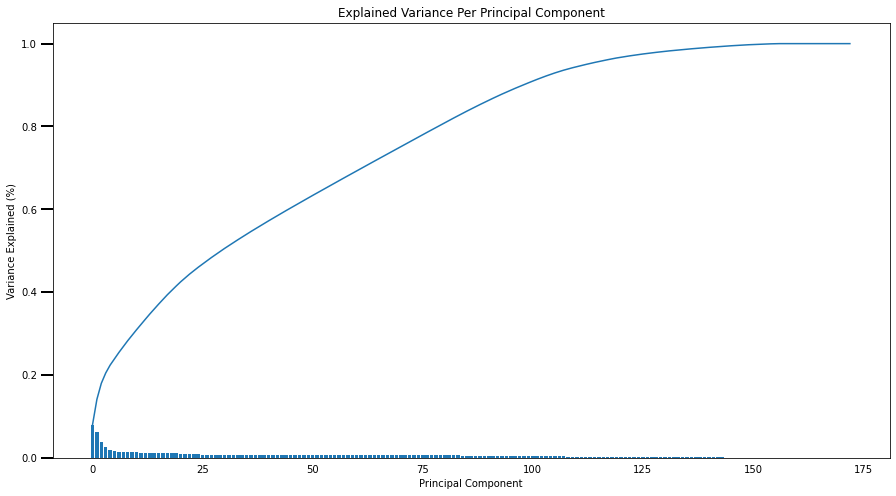

In [134]:
# Investigate the variance accounted for by each principal component.

# From Udacity's course
def scree_plot(pca):
    '''
    Creates a scree plot associated with the principal components 
    
    INPUT: pca - the result of instantian of PCA in scikit learn
            
    OUTPUT:
            None
    '''
    num_components=len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(15, 8))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
#     for i in range(num_components):
#         ax.annotate(r"%s%%" % ((str(vals[i]*100)[:4])), (ind[i]+0.2, vals[i]), va="bottom", ha="center", fontsize=12)
 
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')
    
scree_plot(pca)

In [135]:
# Re-apply PCA to the data while selecting for number of components to retain.

num_components=len(pca.explained_variance_ratio_)
vals = pca.explained_variance_ratio_

cumvals = np.cumsum(vals)
ind = next(x[0] for x in enumerate(cumvals) if x[1] > 0.8)
num_comps = ind+1
num_comps

80

In [136]:
# 80 PCA components --> allow us to capture almost 80% of data variability
cumvals[79]

0.8031621217474525

In [137]:
pca = PCA(n_components=80)
X_azdias_pca = pca.fit_transform(X_azdias)

### Discussion 2.2: Perform Dimensionality Reduction

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding dimensionality reduction. How many principal components / transformed features are you retaining for the next step of the analysis?)

- With only 80 PCA components the dimensions of our dataset can be reduced by half, from 173 features. 
- And still allow us to capture about 80% of data variability.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, **each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components)**. The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. **If** two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. **To contrast**, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should **map** each weight to their corresponding feature name, **then** sort the features according to weight. The most interesting features for each principal component, **then**, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret **feature associations** from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [138]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.


In [139]:
# Comonents --> are list of vectors with some weights for each feature
# 80 components/vectors --> each with 173 (the number of features) weights
print(len(pca.components_))
len(pca.components_[0])

80


173

In [140]:
pca_comp = pd.DataFrame(np.round(pca.components_, 4), columns=azdias_clean.keys()).iloc[1]
pca_comp.head()

ALTERSKATEGORIE_GROB    0.2194
ANREDE_KZ               0.0476
FINANZ_MINIMALIST       0.0455
FINANZ_SPARER          -0.2031
FINANZ_VORSORGER        0.2011
Name: 1, dtype: float64

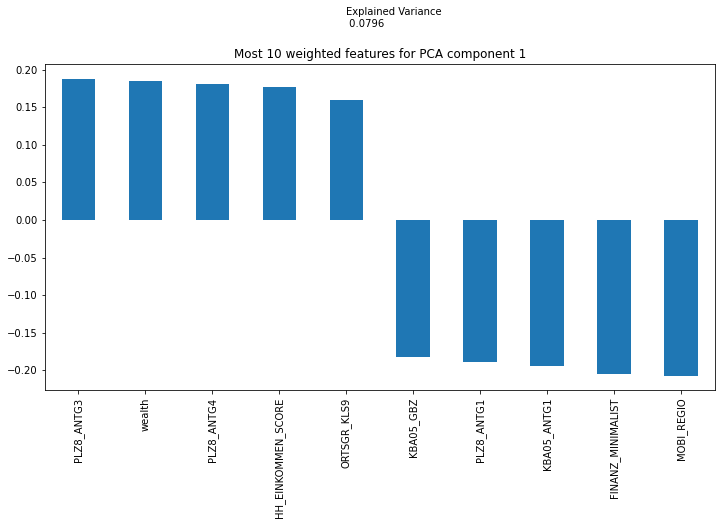

PLZ8_ANTG3            0.1874
wealth                0.1848
PLZ8_ANTG4            0.1810
HH_EINKOMMEN_SCORE    0.1766
ORTSGR_KLS9           0.1602
KBA05_GBZ            -0.1830
PLZ8_ANTG1           -0.1888
KBA05_ANTG1          -0.1943
FINANZ_MINIMALIST    -0.2051
MOBI_REGIO           -0.2071
Name: 0, dtype: float64


In [141]:
def pca_results(df, pca, component_no, n_features):    
    # Build a dataframe with features_no features capturing most variability
    # for a given component number (component_no) -->  -1 because 0-based indexing
    pca_comp = pd.DataFrame(np.round(pca.components_, 4), columns=df.keys()).iloc[component_no - 1]
    pca_comp.sort_values(ascending=False, inplace=True)
    pca_comp = pd.concat([pca_comp.head(n_features), pca_comp.tail(n_features)])
    
    # Plot the result
    pca_comp.plot(kind='bar', 
                  title='Most {} weighted features for PCA component {}'.format(n_features*2, component_no),
                  figsize=(12, 6))
    
    ax = plt.gca()
    ax.text(4, ax.get_ylim()[1] + 0.05, "Explained Variance\n %.4f"%(pca.explained_variance_ratio_[component_no-1]))
    
    plt.show()
    
    return pca_comp


# # Check first 3 components
# for i in np.arange(0, 3, 1):
#     res = pca_results(azdias_clean_scaled, pca, i, 5)
#     print(res)

res = pca_results(azdias_clean, pca, 1, 5)
print(res)

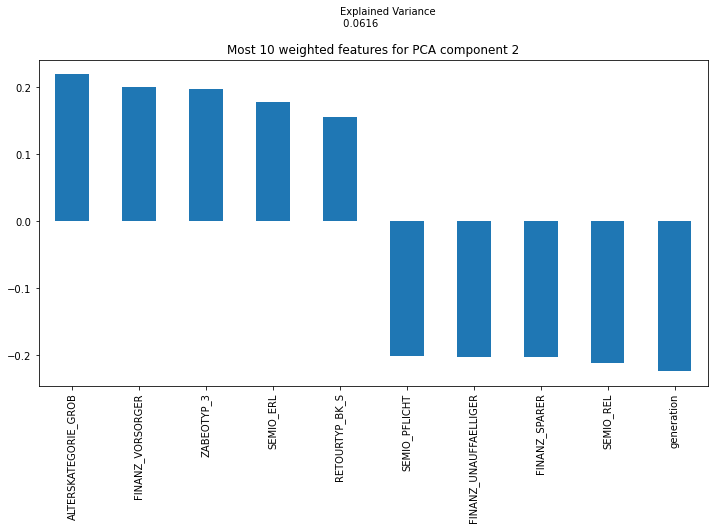

ALTERSKATEGORIE_GROB     0.2194
FINANZ_VORSORGER         0.2011
ZABEOTYP_3               0.1976
SEMIO_ERL                0.1786
RETOURTYP_BK_S           0.1562
SEMIO_PFLICHT           -0.2013
FINANZ_UNAUFFAELLIGER   -0.2031
FINANZ_SPARER           -0.2031
SEMIO_REL               -0.2111
generation              -0.2237
Name: 1, dtype: float64


In [142]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.

res = pca_results(azdias_clean, pca, 2, 5)
print(res)

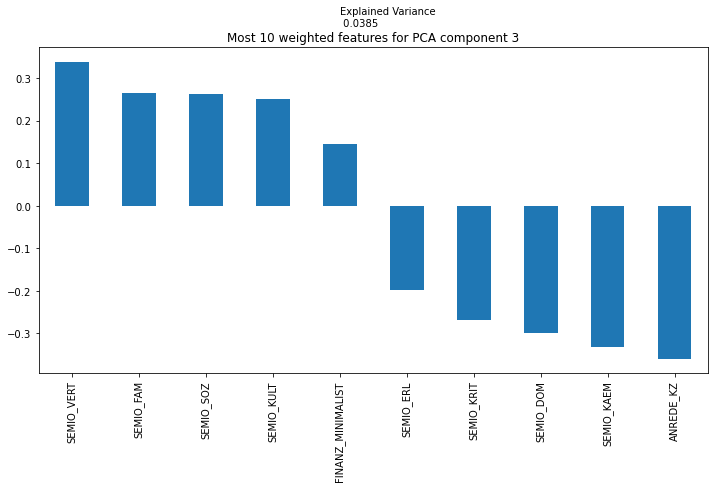

SEMIO_VERT           0.3373
SEMIO_FAM            0.2652
SEMIO_SOZ            0.2633
SEMIO_KULT           0.2513
FINANZ_MINIMALIST    0.1440
SEMIO_ERL           -0.1984
SEMIO_KRIT          -0.2677
SEMIO_DOM           -0.2986
SEMIO_KAEM          -0.3320
ANREDE_KZ           -0.3592
Name: 2, dtype: float64


In [143]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.

res = pca_results(azdias_clean, pca, 3, 5)
print(res)

>### 1.20. SEMIO_SOZ, SEMIO_FAM, SEMIO_REL, SEMIO_MAT, SEMIO_VERT, SEMIO_LUST,
>###       SEMIO_ERL, SEMIO_KULT, SEMIO_RAT, SEMIO_KRIT, SEMIO_DOM, SEMIO_KAEM,
>###       SEMIO_PFLICHT, SEMIO_TRADV
Personality typology, for each dimension:
- -1: unknown
-  1: highest affinity
-  2: very high affinity
-  3: high affinity
-  4: average affinity
-  5: low affinity
-  6: very low affinity
-  7: lowest affinity
-  9: unknown

### Discussion 2.3: Interpret Principal Components

(Double-click this cell and replace this text with your own text, reporting your observations from detailed investigation of the first few principal components generated. Can we interpret positive and negative values from them in a meaningful way?)

- We investigated the top 10 weighted features (5 +ve and 5 -ve). 
- The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. 
- If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. 
- To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

---

<a id='cluster'></a>
## Step 3: Clustering
<ul>
<li><a href="#load">Step 0: Load the Data</a></li>
<li><a href="#process">Step 1: Preprocessing</a></li>
<li><a href="#feat_trans">Step 2: Feature Transformation</a></li>
<li><a href="#cluster"><b>Step 3: Clustering</b></a></li>  
<li><a href="#end">End of Notebook</a></li>  
</ul>

### Step 3.1: Apply Clustering to General Population

You've **assessed and cleaned** the demographics data, then **scaled and transformed** them. Now, it's time to see how the data **clusters** in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [144]:
# Create a toy dataset to reduce computation time
# Reduce the size to 25%
pca_azdias_sample = X_azdias_pca[np.random.choice(X_azdias_pca.shape[0], int(azdias_clean.shape[0]*0.25), replace=False)]
# pca_azdias_sample 

https://stackoverflow.com/questions/40907775/scikit-learn-kmeans-how-to-use-max-iter

In [145]:
# Over a number of different cluster counts...
    # run k-means clustering on the data and...   
    # compute the average within-cluster distances.

from sklearn.cluster import KMeans

t0 = time()
sse = [] # Sum of Squared Errors
k_range = np.arange(10, 31)

for k in k_range:
    kmeans = KMeans(k, random_state=42, max_iter=30)
    model = kmeans.fit(pca_azdias_sample)
    score = np.abs(kmeans.score(pca_azdias_sample))
    sse.append(score)
    print('Clustering done for {} k, with SSE {}'.format(k, round(score, 2)))

print('-'*20)    
print((time()-t0)/60)

Clustering done for 10 k, with SSE 16934382.01
Clustering done for 11 k, with SSE 16764315.09
Clustering done for 12 k, with SSE 16676983.86
Clustering done for 13 k, with SSE 16547565.71
Clustering done for 14 k, with SSE 16436246.68
Clustering done for 15 k, with SSE 16274704.39
Clustering done for 16 k, with SSE 16177655.0
Clustering done for 17 k, with SSE 15995359.02
Clustering done for 18 k, with SSE 15973367.22
Clustering done for 19 k, with SSE 15771742.86
Clustering done for 20 k, with SSE 15717453.05
Clustering done for 21 k, with SSE 15577138.69
Clustering done for 22 k, with SSE 15423173.79
Clustering done for 23 k, with SSE 15408473.07
Clustering done for 24 k, with SSE 15299429.22
Clustering done for 25 k, with SSE 15215985.81
Clustering done for 26 k, with SSE 15120649.41
Clustering done for 27 k, with SSE 14996843.5
Clustering done for 28 k, with SSE 14826711.75
Clustering done for 29 k, with SSE 14730060.21
Clustering done for 30 k, with SSE 14656372.59
---------------

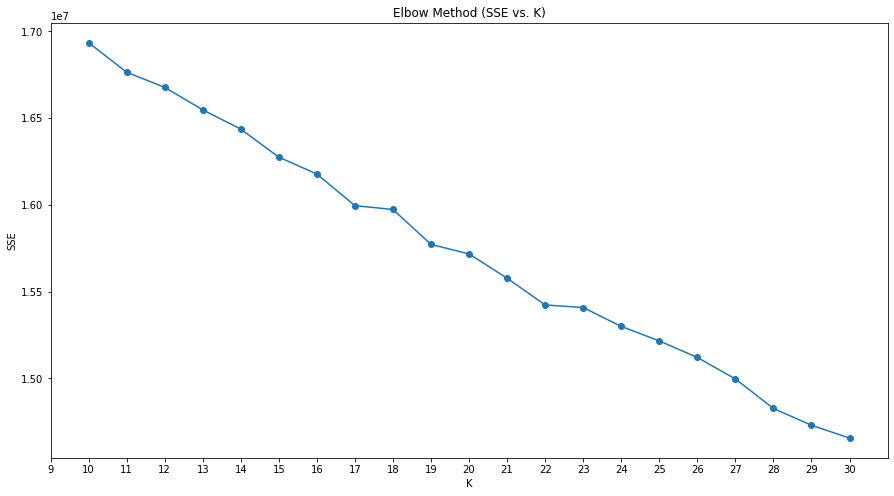

In [146]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.

# Use the Elbow Method to identify the right value of k
plt.figure(figsize=(15, 8))
plt.xticks(np.arange(0, k_range[-1]+1, step=1))
plt.xlabel('K')
plt.ylabel('SSE')
plt.title('Elbow Method (SSE vs. K)')
plt.plot(k_range, sse, linestyle='-', marker='o');

In [147]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
t0 = time()

kmeans_25 = KMeans(n_clusters = 25, random_state=42)
model = kmeans_25.fit(X_azdias_pca)
population_clusters = model.predict(X_azdias_pca)

print(time()-t0)

52.125417947769165


### Discussion 3.1: Apply Clustering to General Population

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding clustering. Into how many clusters have you decided to segment the population?)

- Created a toy dataset (25% of rows) to reduce computation time
- Used Elbow Method the plot starts to flatten more after K = 25 
- so 25 clusters were used.

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [148]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', sep=';')
print(customers.shape), print('-'*15)
print(customers.dtypes.value_counts())
customers.head()

(191652, 85)
---------------
float64    49
int64      32
object      4
dtype: int64


,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GEBURTSJAHR,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,TITEL_KZ,VERS_TYP,ZABEOTYP,ALTER_HH,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,KK_KUNDENTYP,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_DEUG_2015,CAMEO_DEU_2015,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_BAUMAX,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2,4,1,5.0,5,1,5,1,2,2,2,0,4.0,1,1,20.0,5.0,2.0,2.0,10.0,5.0,1,4,5.0,6,5,2,6,6,7,3,4,1,3,1,1,2,1,3,0.0,0.0,1,3,10.0,2.0,0.0,1.0,NaN,6.0,9.0,1.0,0.0,1.0,5.0,1992.0,W,7.0,1,1A,13,2.0,2.0,0.0,0.0,0.0,4.0,3.0,2.0,4.0,4.0,1.0,4.0,3.0,1.0,1201.0,3.0,3.0,1.0,0.0,1.0,5.0,5.0,1.0,2.0,1.0
1,-1,4,1,NaN,5,1,5,1,3,2,2,0,NaN,0,1,NaN,NaN,NaN,NaN,NaN,NaN,1,0,NaN,3,6,2,6,7,5,3,4,1,3,3,2,4,1,3,0.0,0.0,1,3,11.0,3.0,0.0,NaN,NaN,0.0,9.0,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-1,4,2,2.0,5,1,5,1,4,4,2,0,3.0,1,2,13.0,3.0,1.0,1.0,10.0,5.0,1,4,5.0,2,2,1,3,3,7,7,1,2,7,5,6,4,1,1,0.0,0.0,2,3,6.0,1.0,0.0,1.0,NaN,6.0,9.0,1.0,0.0,8.0,1.0,1992.0,W,2.0,5,5D,34,2.0,2.0,0.0,0.0,0.0,3.0,7.0,4.0,1.0,3.0,3.0,3.0,1.0,7.0,433.0,2.0,3.0,3.0,1.0,3.0,3.0,2.0,3.0,5.0,3.0
3,1,4,1,2.0,5,1,5,2,1,2,6,0,10.0,0,2,0.0,0.0,0.0,0.0,9.0,4.0,1,1,3.0,6,5,3,4,7,5,3,4,3,3,3,3,3,4,0,0.0,0.0,1,1,8.0,0.0,0.0,4.0,NaN,NaN,9.0,0.0,NaN,2.0,2.0,1992.0,W,7.0,4,4C,24,3.0,0.0,0.0,0.0,1.0,4.0,7.0,1.0,7.0,4.0,3.0,4.0,2.0,6.0,755.0,3.0,2.0,1.0,0.0,1.0,3.0,4.0,1.0,3.0,1.0
4,-1,3,1,6.0,3,1,4,4,5,2,2,1960,2.0,0,3,31.0,10.0,10.0,5.0,1.0,1.0,1,8,5.0,4,5,4,6,5,6,4,5,5,3,5,2,5,4,1,0.0,0.0,2,1,20.0,4.0,0.0,6.0,2.0,2.0,9.0,7.0,0.0,3.0,1.0,1992.0,W,3.0,7,7B,41,0.0,3.0,2.0,0.0,0.0,3.0,3.0,4.0,4.0,3.0,4.0,3.0,5.0,7.0,513.0,2.0,4.0,2.0,1.0,2.0,3.0,3.0,3.0,5.0,1.0


In [149]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.


In [150]:
### Step 1: Preprocessing
customers_clean = clean_data(customers)
print(customers_clean.shape), print('-'*15)
print(customers_clean.dtypes.value_counts())
customers_clean.head()

(121111, 169)
---------------
uint8      108
float64     36
int64       25
dtype: int64


,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SOHO_KZ,VERS_TYP,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,MOBI_REGIO,ONLINE_AFFINITAET,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,LP_STATUS_FEIN_2.0,LP_STATUS_FEIN_3.0,LP_STATUS_FEIN_4.0,LP_STATUS_FEIN_5.0,LP_STATUS_FEIN_6.0,LP_STATUS_FEIN_7.0,LP_STATUS_FEIN_8.0,LP_STATUS_FEIN_9.0,LP_STATUS_FEIN_10.0,SHOPPER_TYP_1.0,SHOPPER_TYP_2.0,SHOPPER_TYP_3.0,ZABEOTYP_2,ZABEOTYP_3,ZABEOTYP_4,ZABEOTYP_5,ZABEOTYP_6,NATIONALITAET_KZ_2.0,NATIONALITAET_KZ_3.0,LP_FAMILIE_FEIN_2.0,LP_FAMILIE_FEIN_3.0,LP_FAMILIE_FEIN_4.0,LP_FAMILIE_FEIN_5.0,LP_FAMILIE_FEIN_6.0,LP_FAMILIE_FEIN_7.0,LP_FAMILIE_FEIN_8.0,LP_FAMILIE_FEIN_9.0,LP_FAMILIE_FEIN_10.0,LP_FAMILIE_FEIN_11.0,CAMEO_DEUG_2015_2.0,CAMEO_DEUG_2015_3.0,CAMEO_DEUG_2015_4.0,CAMEO_DEUG_2015_5.0,CAMEO_DEUG_2015_6.0,CAMEO_DEUG_2015_7.0,CAMEO_DEUG_2015_8.0,CAMEO_DEUG_2015_9.0,GEBAEUDETYP_3.0,GEBAEUDETYP_8.0,CAMEO_DEU_2015_1B,CAMEO_DEU_2015_1C,CAMEO_DEU_2015_1D,CAMEO_DEU_2015_1E,CAMEO_DEU_2015_2A,CAMEO_DEU_2015_2B,CAMEO_DEU_2015_2C,CAMEO_DEU_2015_2D,CAMEO_DEU_2015_3A,CAMEO_DEU_2015_3B,CAMEO_DEU_2015_3C,CAMEO_DEU_2015_3D,CAMEO_DEU_2015_4A,CAMEO_DEU_2015_4B,CAMEO_DEU_2015_4C,CAMEO_DEU_2015_4D,CAMEO_DEU_2015_4E,CAMEO_DEU_2015_5A,CAMEO_DEU_2015_5B,CAMEO_DEU_2015_5C,CAMEO_DEU_2015_5D,CAMEO_DEU_2015_5E,CAMEO_DEU_2015_5F,CAMEO_DEU_2015_6A,CAMEO_DEU_2015_6B,CAMEO_DEU_2015_6C,CAMEO_DEU_2015_6D,CAMEO_DEU_2015_6E,CAMEO_DEU_2015_6F,CAMEO_DEU_2015_7A,CAMEO_DEU_2015_7B,CAMEO_DEU_2015_7C,CAMEO_DEU_2015_7D,CAMEO_DEU_2015_7E,CAMEO_DEU_2015_8A,CAMEO_DEU_2015_8B,CAMEO_DEU_2015_8C,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,GFK_URLAUBERTYP_2.0,GFK_URLAUBERTYP_3.0,GFK_URLAUBERTYP_4.0,GFK_URLAUBERTYP_5.0,GFK_URLAUBERTYP_6.0,GFK_URLAUBERTYP_7.0,GFK_URLAUBERTYP_8.0,GFK_URLAUBERTYP_9.0,GFK_URLAUBERTYP_10.0,GFK_URLAUBERTYP_11.0,GFK_URLAUBERTYP_12.0,FINANZTYP_2,FINANZTYP_3,FINANZTYP_4,FINANZTYP_5,FINANZTYP_6,LP_STATUS_GROB_2.0,LP_STATUS_GROB_3.0,LP_FAMILIE_GROB_3.0,LP_FAMILIE_GROB_4.0,LP_FAMILIE_GROB_5.0,CJT_GESAMTTYP_2.0,CJT_GESAMTTYP_3.0,CJT_GESAMTTYP_4.0,CJT_GESAMTTYP_5.0,CJT_GESAMTTYP_6.0,generation,wealth,life_stage
0,4.0,0,5,1,5,1,2,2,1,1.0,5.0,6,5,2,6,6,7,3,4,1,3,1,1,2,1,0.0,0.0,2.0,0.0,1.0,6.0,9.0,1.0,0.0,5.0,1992.0,1,2.0,2.0,0.0,0.0,4.0,3.0,2.0,4.0,4.0,4.0,3.0,1201.0,3.0,3.0,1.0,0.0,5.0,5.0,1.0,2.0,1.0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,2.0,1,3
2,4.0,1,5,1,5,1,4,4,1,2.0,5.0,2,2,1,3,3,7,7,1,2,7,5,6,4,1,0.0,1.0,1.0,0.0,1.0,6.0,9.0,1.0,0.0,1.0,1992.0,1,2.0,2.0,0.0,0.0,3.0,7.0,4.0,1.0,3.0,3.0,1.0,433.0,2.0,3.0,3.0,1.0,3.0,2.0,3.0,5.0,3.0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,2.0,3,4
4,3.0,0,3,1,4,4,5,2,0,3.0,5.0,4,5,4,6,5,6,4,5,5,3,5,2,5,4,0.0,1.0,4.0,0.0,6.0,2.0,9.0,7.0,0.0,1.0,1992.0,1,0.0,3.0,2.0,0.0,3.0,3.0,4.0,4.0,3.0,3.0,5.0,513.0,2.0,4.0,2.0,1.0,3.0,3.0,3.0,5.0,1.0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,4.0,4,1
5,3.0,0,5,1,5,1,2,3,1,3.0,3.0

In [151]:
### Step 2: Feature Transformation
# # Remove rows with NaNs
# customers_clean = customers_clean.dropna()

# Apply feature scaling to the customers demographics data
scaler = StandardScaler()
X_customers = scaler.fit_transform(customers_clean)

# Apply PCA to the data
X_customers_pca = pca.fit_transform(X_customers)

> **NOTE:**
>- we can use the previous population model to cluster customers,
>- or we can cluster it separately to the same number of population clusters --> 25

**<font color='red'>Is it better to use the trained population model in clustering customers ?! </font>** <br>
well, I think it is better as the model is trained using much more datapoints

In [152]:
### Step 3: Clustering
# Cluster predictions for the customers demographics data.
t0 = time()

# kmeans_25 = KMeans(n_clusters = 25, random_state=42)
# model = kmeans_25.fit(X_customers_pca)
customer_clusters = model.predict(X_customers_pca)

print(time()-t0)

0.05732989311218262


<br>

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. 
- **If** we think the company's customer base to be universal, **then** the cluster assignment proportions should be fairly similar between the two. 
- **If** there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. 
- **If** there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) **then** that suggests the people in that cluster to be a target audience for the company.
- **On the other hand**, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) **suggests that** group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- **Which cluster or clusters are overrepresented in the customer dataset compared to the general population?** Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. **Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?**

In [153]:
# figure, axs = plt.subplots(nrows=1, ncols=2, figsize = (15,8))
# figure.subplots_adjust(hspace = 1, wspace=.3)

# sns.countplot(customer_clusters, ax=axs[0])
# axs[0].set_title('Customer Clusters')
# sns.countplot(population_clusters, ax=axs[1])
# axs[1].set_title('Population Clusters');

In [154]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

# Create a dataset summarizing clustering information
# _c --> count
population_clusters_c = pd.Series(population_clusters).value_counts().sort_index()
customer_clusters_c = pd.Series(customer_clusters).value_counts().sort_index()

# The count of dropped rows with missing values
n_nans_population = azdias_with_nans.shape[0]
n_nans_customers = customers[customers.isnull().any(axis=1)].shape[0]

my_dict = {'population':population_clusters_c, 'customers': customer_clusters_c}
df_counts = pd.DataFrame(my_dict)
# Add missing rows cluster
df_counts.loc[-1] = [n_nans_population, n_nans_customers]

# Calculate proprotions
df_counts['cust_prop'] = df_counts['customers'] / df_counts['customers'].sum()
df_counts['pop_prop'] = df_counts['population'] / df_counts['population'].sum()
df_counts.sort_index(inplace=True)
df_counts = df_counts.rename_axis('cluster').reset_index()
df_counts

,cluster,population,customers,cust_prop,pop_prop
0,-1,268012,70541,0.368068,0.300725
1,0,19507,870,0.004539,0.021888
2,1,19345,1827,0.009533,0.021706
3,2,26994,1924,0.010039,0.030289
4,3,24288,4598,0.023991,0.027252
5,4,31191,4967,0.025917,0.034998
6,5,31236,4687,0.024456,0.035049
7,6,30503,9677,0.050493,0.034226
8,7,50489,13020,0.067936,0.056651
9,8,39668,12316,0.064262,0.044510


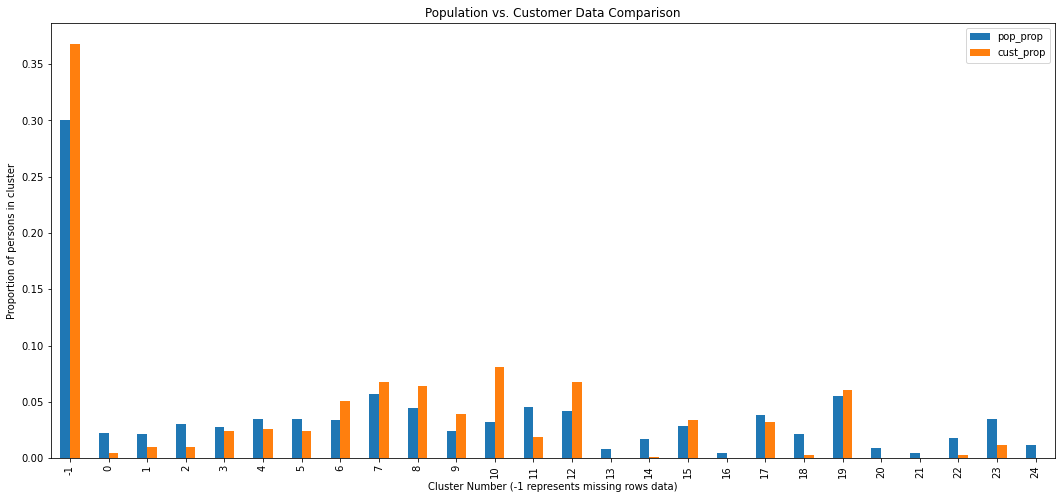

In [155]:
# Compare visually
df_counts.plot(x='cluster', y=['pop_prop', 'cust_prop'], kind='bar', figsize=(18, 8))
plt.title('Population vs. Customer Data Comparison')
plt.xlabel('Cluster Number (-1 represents missing rows data)')
plt.ylabel('Proportion of persons in cluster')
plt.show()

**CLuster 10**

In [156]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?

# Let's take cluster 10 as an example

In [157]:
len(model.cluster_centers_[10])

80

In [170]:
# Let's examine people of cluster 10
# 5 top principal components of cluster 10
centroid_10 = pd.Series(model.cluster_centers_[10]).sort_values(ascending=False)
centroid_10.head(5)

2     2.934541
3     1.670340
18    1.045079
15    0.543678
7     0.311838
dtype: float64

In [159]:
len(centroid_10)

80

In [160]:
before_pca = pca.inverse_transform(centroid_10)
len(before_pca)

169

https://www.quora.com/How-do-I-solve-ValueError-Expected-2D-array-got-1D-array-instead-error-in-Python

In [161]:
# [1,2,3] --> [[1,2,3]] 
before_pca = before_pca.reshape(1,-1)

In [171]:
# Transform cluster 10 to original feature values
centroid_10 = scaler.inverse_transform(pca.inverse_transform(model.cluster_centers_[10].reshape(1,-1)))
centroid_10 = pd.Series(centroid_10[0], index = customers_clean.columns).round()
centroid_10

ALTERSKATEGORIE_GROB        3.0
ANREDE_KZ                  -0.0
FINANZ_MINIMALIST           5.0
FINANZ_SPARER               1.0
FINANZ_VORSORGER            5.0
FINANZ_ANLEGER              1.0
FINANZ_UNAUFFAELLIGER       2.0
FINANZ_HAUSBAUER            1.0
GREEN_AVANTGARDE            1.0
HEALTH_TYP                  2.0
RETOURTYP_BK_S              4.0
SEMIO_SOZ                   5.0
SEMIO_FAM                   5.0
SEMIO_REL                   4.0
SEMIO_MAT                   5.0
SEMIO_VERT                  7.0
SEMIO_LUST                  5.0
SEMIO_ERL                   3.0
SEMIO_KULT                  6.0
SEMIO_RAT                   3.0
SEMIO_KRIT                  2.0
SEMIO_DOM                   3.0
SEMIO_KAEM                  2.0
SEMIO_PFLICHT               4.0
SEMIO_TRADV                 4.0
SOHO_KZ                     0.0
VERS_TYP                    0.0
ANZ_PERSONEN                3.0
ANZ_TITEL                   0.0
HH_EINKOMMEN_SCORE          1.0
W_KEIT_KIND_HH              4.0
WOHNDAUE

<br>

**Component 2**

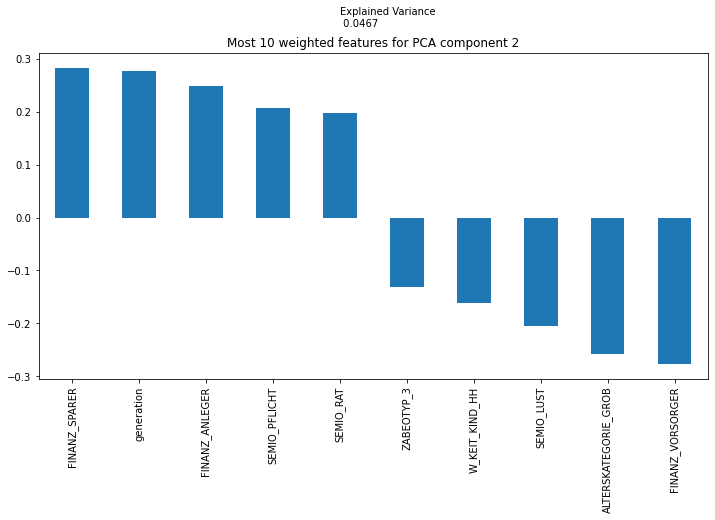

FINANZ_SPARER           0.2837
generation              0.2767
FINANZ_ANLEGER          0.2484
SEMIO_PFLICHT           0.2068
SEMIO_RAT               0.1977
ZABEOTYP_3             -0.1317
W_KEIT_KIND_HH         -0.1623
SEMIO_LUST             -0.2044
ALTERSKATEGORIE_GROB   -0.2578
FINANZ_VORSORGER       -0.2771
Name: 1, dtype: float64

In [172]:
# Analyze 2 top principal components of cluster 10
pca_results(customers_clean, pca, 2, 5)

> **NOTE:**
>- component 2 is most affected by: Financial typology | generation | Personality typology | age
     - **+ve relationship with: money-saver | generation | investor | dutiful | rational**
     - **<font color='red'> -ve relationship with: be prepared (Financial) | age | sensual-minded | Likelihood of children in household | Energy consumption typology</font>**

> **NOTE:** generation is inversely proportional with age

>### 1.5. FINANZ_MINIMALIST, FINANZ_SPARER, FINANZ_VORSORGER, FINANZ_ANLEGER,
>###      FINANZ_UNAUFFAELLIGER, FINANZ_HAUSBAUER
Financial typology, for each dimension:
- -1: unknown
-  1: very high
-  2: high
-  3: average
-  4: low
-  5: very low

>Dimension translations:
- MINIMALIST: low financial interest
- **SPARER: money-saver**
- **<font color='red'>VORSORGER: be prepared</font>**
- **ANLEGER: investor**
- UNAUFFAELLIGER: inconspicuous
- HAUSBAUER: home ownership

>### 1.20. SEMIO_SOZ, SEMIO_FAM, SEMIO_REL, SEMIO_MAT, SEMIO_VERT, SEMIO_LUST,
>###       SEMIO_ERL, SEMIO_KULT, SEMIO_RAT, SEMIO_KRIT, SEMIO_DOM, SEMIO_KAEM,
>###       SEMIO_PFLICHT, SEMIO_TRADV
Personality typology, for each dimension:
- -1: unknown
-  1: highest affinity
-  2: very high affinity
-  3: high affinity
-  4: average affinity
-  5: low affinity
-  6: very low affinity
-  7: lowest affinity
-  9: unknown

>Dimension translations:
- SOZ: socially-minded
- FAM: family-minded**
- REL: religious
- MAT: materialistic
- VERT: dreamful
- **<font color='red'>LUST: sensual-minded</font>**
- **<font color='red'>ERL: event-oriented </font>**
- KULT: cultural-minded
- **RAT: rational**
- KRIT: critical-minded 
- DOM: dominant-minded 
- KAEM: combative attitude 
- **PFLICHT: dutiful**
- TRADV: tradional-minded

>### **<font color='red'>1.2. ALTERSKATEGORIE_GROB</font>**
Estimated age based on given name analysis
- -1: unknown (missing)
-  0: unknown (cannot be determined)
-  1: < 30 years old
-  2: 30 - 45 years old
-  3: 46 - 60 years old
-  4: > 60 years old
-  9: uniformly distributed

>### **<font color='red'>1.25. ZABEOTYP</font>**
Energy consumption typology
- -1: unknown
-  1: green
-  2: smart
-  3: fair supplied
-  4: price driven
-  5: seeking orientation
-  6: indifferent
-  9: unknown

>### **<font color='red'>2.6. W_KEIT_KIND_HH</font>**
Likelihood of children in household
- -1: unknown
-  0: unknown
-  1: most likely
-  2: very likely
-  3: likely
-  4: average
-  5: unlikely
-  6: very unlikely

**Component 3**

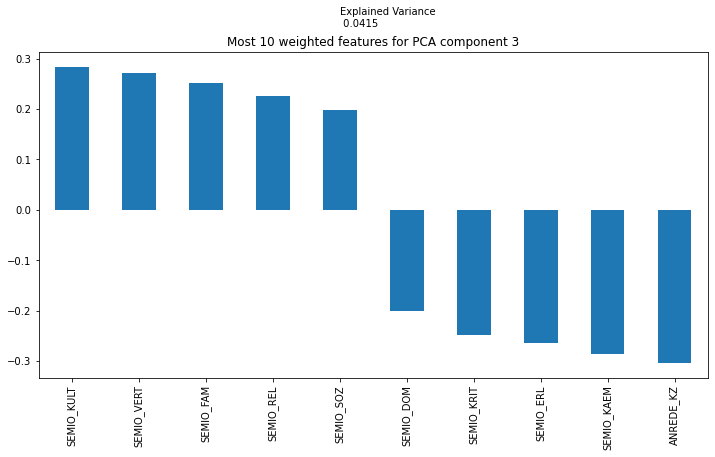

SEMIO_KULT    0.2842
SEMIO_VERT    0.2714
SEMIO_FAM     0.2516
SEMIO_REL     0.2253
SEMIO_SOZ     0.1974
SEMIO_DOM    -0.2014
SEMIO_KRIT   -0.2484
SEMIO_ERL    -0.2634
SEMIO_KAEM   -0.2855
ANREDE_KZ    -0.3040
Name: 2, dtype: float64

In [164]:
# Analyze 2 top principal components of cluster 10
pca_results(customers_clean, pca, 3, 5)

- component 3 is most affected by: Personality typology
    - **+ve relationship with: cultural-minded | dreamful | family-minded | religious | socially-minded **
    - **<font color='red'> -ve relationship with: Gender(female) | combative attitude | event-oriented  | critical-minded | dominant-minded </font>**

>### 1.20. SEMIO_SOZ, SEMIO_FAM, SEMIO_REL, SEMIO_MAT, SEMIO_VERT, SEMIO_LUST,
>###       SEMIO_ERL, SEMIO_KULT, SEMIO_RAT, SEMIO_KRIT, SEMIO_DOM, SEMIO_KAEM,
>###       SEMIO_PFLICHT, SEMIO_TRADV
Personality typology, for each dimension:
- -1: unknown
-  1: highest affinity
-  2: very high affinity
-  3: high affinity
-  4: average affinity
-  5: low affinity
-  6: very low affinity
-  7: lowest affinity
-  9: unknown

>Dimension translations:
- **SOZ: socially-minded**
- **FAM: family-minded**
- **REL: religious**
- MAT: materialistic
- **VERT: dreamful**
- LUST: sensual-minded
- **<font color='red'>ERL: event-oriented </font>**
- **KULT: cultural-minded**
- RAT: rational
- **<font color='red'>KRIT: critical-minded </font>**
- **<font color='red'> DOM: dominant-minded </font>**
- **<font color='red'>KAEM: combative attitude </font>**
- PFLICHT: dutiful
- TRADV: tradional-minded
    
>### 1.3. <font color='red'>ANREDE_KZ </font>
Gender
- -1: unknown (missing)
-  0: unknown (cannot be determined)
-  1: male
-  2: female

<br>

<br>

**cluster 2**

In [165]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?

# Let's take cluster 2 as an example

In [176]:
# Let's examine people of cluster 2
# 5 top principal components of cluster 2
centroid_2 = pd.Series(model.cluster_centers_[2]).sort_values(ascending=False)
centroid_2.head(5)

1     2.709720
11    2.200305
12    2.170881
0     1.373480
13    0.883304
dtype: float64

In [177]:
# Transform cluster 2 to original feature values
centroid_2 = scaler.inverse_transform(pca.inverse_transform(model.cluster_centers_[2].reshape(1,-1)))
centroid_2 = pd.Series(centroid_2[0], index = customers_clean.columns).round()
centroid_2

ALTERSKATEGORIE_GROB        3.0
ANREDE_KZ                   0.0
FINANZ_MINIMALIST           4.0
FINANZ_SPARER               2.0
FINANZ_VORSORGER            4.0
FINANZ_ANLEGER              2.0
FINANZ_UNAUFFAELLIGER       3.0
FINANZ_HAUSBAUER            3.0
GREEN_AVANTGARDE            0.0
HEALTH_TYP                  2.0
RETOURTYP_BK_S              4.0
SEMIO_SOZ                   5.0
SEMIO_FAM                   4.0
SEMIO_REL                   4.0
SEMIO_MAT                   3.0
SEMIO_VERT                  5.0
SEMIO_LUST                  5.0
SEMIO_ERL                   5.0
SEMIO_KULT                  4.0
SEMIO_RAT                   4.0
SEMIO_KRIT                  4.0
SEMIO_DOM                   4.0
SEMIO_KAEM                  4.0
SEMIO_PFLICHT               4.0
SEMIO_TRADV                 4.0
SOHO_KZ                    -0.0
VERS_TYP                    1.0
ANZ_PERSONEN                2.0
ANZ_TITEL                  -0.0
HH_EINKOMMEN_SCORE          4.0
W_KEIT_KIND_HH              4.0
WOHNDAUE

<br>

**Component 1**

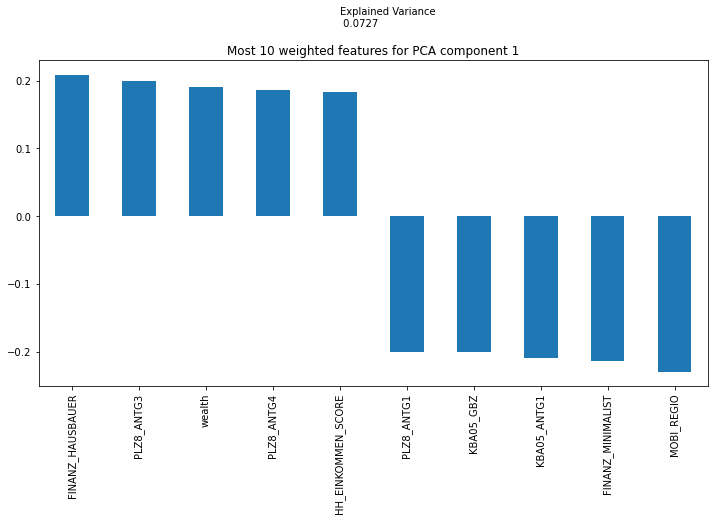

FINANZ_HAUSBAUER      0.2082
PLZ8_ANTG3            0.1994
wealth                0.1905
PLZ8_ANTG4            0.1865
HH_EINKOMMEN_SCORE    0.1838
PLZ8_ANTG1           -0.2005
KBA05_GBZ            -0.2007
KBA05_ANTG1          -0.2092
FINANZ_MINIMALIST    -0.2143
MOBI_REGIO           -0.2292
Name: 0, dtype: float64

In [178]:
# Analyze 2 top principal components of cluster 2
pca_results(customers_clean, pca, 1, 5)

> **NOTE:**
>- component 1 is most affected by: Financial typology | Number of family houses | Estimated household net income
    - **+ve relationship with: home ownership | 6-10 family houses in the PLZ8 region | wealth | 10+ family houses in the PLZ8 region | Estimated household net income**
    - **<font color='red'> -ve relationship with: Movement patterns | low financial interest | 1-2 family houses in the microcell | Number of buildings in the microcell | 1-2 family houses in the PLZ8 region </font>**

>### 1.5. FINANZ_MINIMALIST, FINANZ_SPARER, FINANZ_VORSORGER, FINANZ_ANLEGER,
>###      FINANZ_UNAUFFAELLIGER, FINANZ_HAUSBAUER
Financial typology, for each dimension:
- -1: unknown
-  1: very high
-  2: high
-  3: average
-  4: low
-  5: very low

>Dimension translations:
- **<font color='red'>MINIMALIST: low financial interest</font>**
- SPARER: money-saver
- VORSORGER: be prepared
- ANLEGER: investor
- UNAUFFAELLIGER: inconspicuous
- **HAUSBAUER: home ownership**

>### 8.2. PLZ8_ANTG1
Number of 1-2 family houses in the PLZ8 region
- -1: unknown
-  0: no 1-2 family homes
-  1: lower share of 1-2 family homes
-  2: average share of 1-2 family homes
-  3: high share of 1-2 family homes
-  4: very high share of 1-2 family homes

>### 8.3. PLZ8_ANTG2
Number of 3-5 family houses in the PLZ8 region
- -1: unknown
-  0: no 3-5 family homes
-  1: lower share of 3-5 family homes
-  2: average share of 3-5 family homes
-  3: high share of 3-5 family homes
-  4: very high share of 3-5 family homes

>### 8.4. PLZ8_ANTG3
Number of 6-10 family houses in the PLZ8 region
- -1: unknown
-  0: no 6-10 family homes
-  1: lower share of 6-10 family homes
-  2: average share of 6-10 family homes
-  3: high share of 6-10 family homes

>### 8.5. PLZ8_ANTG4
Number of 10+ family houses in the PLZ8 region
- -1: unknown
-  0: no 10+ family homes
-  1: lower share of 10+ family homes
-  2: high share of 10+ family homes

>### 2.4. HH_EINKOMMEN_SCORE
Estimated household net income
- -1: unknown
-  0: unknown
-  1: highest income
-  2: very high income
-  3: high income
-  4: average income
-  5: lower income
-  6: very low income

>### 5.6. KBA05_GBZ
Number of buildings in the microcell
- -1: unknown
-  0: unknown
-  1: 1-2 buildings
-  2: 3-4 buildings
-  3: 5-16 buildings
-  4: 17-22 buildings
-  5: >=23 buildings

>### 5.1. KBA05_ANTG1
Number of 1-2 family houses in the microcell
- -1: unknown
-  0: no 1-2 family homes
-  1: lower share of 1-2 family homes
-  2: average share of 1-2 family homes
-  3: high share of 1-2 family homes
-  4: very high share of 1-2 family homes

>### 7.3. MOBI_REGIO
Movement patterns
- 1: very high movement
- 2: high movement
- 3: middle movement
- 4: low movement
- 5: very low movement
- 6: none

<br>

**Component 11**

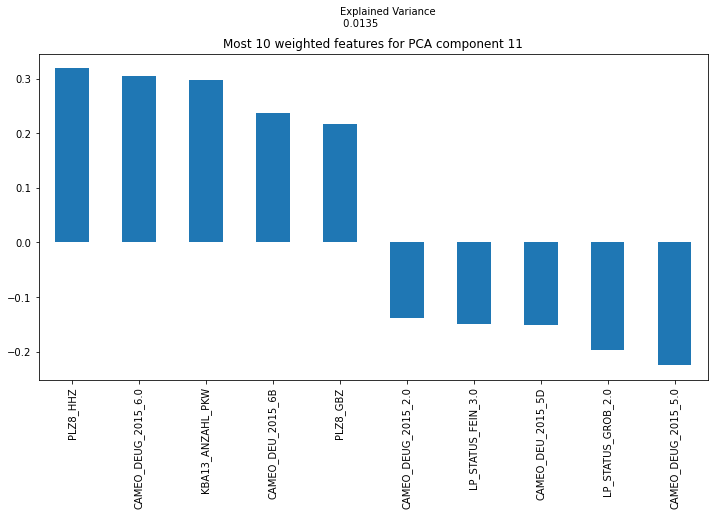

PLZ8_HHZ               0.3186
CAMEO_DEUG_2015_6.0    0.3050
KBA13_ANZAHL_PKW       0.2966
CAMEO_DEU_2015_6B      0.2372
PLZ8_GBZ               0.2160
CAMEO_DEUG_2015_2.0   -0.1375
LP_STATUS_FEIN_3.0    -0.1496
CAMEO_DEU_2015_5D     -0.1508
LP_STATUS_GROB_2.0    -0.1967
CAMEO_DEUG_2015_5.0   -0.2244
Name: 10, dtype: float64

In [179]:
# Analyze 2 top principal components of cluster 2
pca_results(customers_clean, pca, 11, 5)

> **NOTE:**
>- **component 11 is most affected by: Number of households within the PLZ8 region | Wealth / Life Stage Typology | Number of cars in the PLZ8 region | Number of buildings within the PLZ8 region | Social status**
    - **<font color='green'>+ve relationship with: Number of households within the PLZ8 region | low-consumption middleclass | Number of cars in the PLZ8 region | Petty Bourgeois | Number of buildings within the PLZ8 region</font>**
    - **<font color='red'> active middleclass | average earners | Stock Market Junkies  | aspiring low-income earners | upper middleclass </font>**

>## 4. RR4 micro-cell features
>### 4.1. CAMEO_DEUG_2015
German CAMEO: Wealth / Life Stage Typology, rough scale
- -1: unknown
-  1: upper class
-  **<font color='red'>2: upper middleclass</font>**
-  3: established middleclass
-  4: consumption-oriented middleclass
-  **<font color='red'>5: active middleclass</font>**
-  6: **low-consumption middleclass**
-  7: lower middleclass
-  8: working class
-  9: urban working class
-  X: unknown

>### 4.2. CAMEO_DEU_2015
German CAMEO: Wealth / Life Stage Typology, detailed scale
- 1A: Work-Life-Balance
- 1B: Wealthy Best Ager
- 1C: Successful Songwriter
- 1D: Old Nobility
- 1E: City Nobility
- 2A: Cottage Chic
- 2B: Noble Jogger
- 2C: Established gourmet
- 2D: Fine Management
- 3A: Career & Family
- 3B: Powershopping Families
- 3C: Rural Neighborhood
- 3D: Secure Retirement
- 4A: Family Starter
- 4B: Family Life
- 4C: String Trimmer
- 4D: Empty Nest
- 4E: Golden Ager
- 5A: Younger Employees
- 5B: Suddenly Family
- 5C: Family First
- **<font color='red'>5D: Stock Market Junkies</font>**
- 5E: Coffee Rider
- 5F: Active Retirement
- 6A: Jobstarter
- **6B: Petty Bourgeois**
- 6C: Long-established
- 6D: Sportgardener
- 6E: Urban Parents
- 6F: Frugal Aging
- 7A: Journeymen**
- 7B: Mantaplatte
- 7C: Factory Worker
- 7D: Rear Window
- 7E: Interested Retirees
- 8A: Multi-culteral
- 8B: Young & Mobile
- 8C: Prefab
- 8D: Town Seniors
- 9A: First Shared Apartment
- 9B: Temporary Workers
- 9C: Afternoon Talk Show
- 9D: Mini-Jobber
- 9E: Socking Away
- XX: unknown

>### 8.7. PLZ8_HHZ
Number of households within the PLZ8 region
- -1: unknown
-  1: less than 130 households
-  2: 131-299 households
-  3: 300-599 households
-  4: 600-849 households
-  5: more than 849 households

>### 8.1. KBA13_ANZAHL_PKW
Number of cars in the PLZ8 region

>### 8.8. PLZ8_GBZ
Number of buildings within the PLZ8 region
- -1: unknown
-  1: less than 60 buildings
-  2:  60-129 buildings
-  3: 130-299 buildings
-  4: 300-449 buildings
-  5: more than 449 buildings

>### 1.15. LP_STATUS_FEIN
Social status, fine scale
-  1: typical low-income earners
-  2: orientation-seeking low-income earners
-  **<font color='red'>3: aspiring low-income earners</font>**
-  4: villagers
-  5: minimalistic high-income earners
-  6: independent workers
-  7: title holder-households
-  8: new houseowners
-  9: houseowners
- 10: top earners

>### 1.16. LP_STATUS_GROB
Social status, rough scale
- 1: low-income earners (maps to 1-2 in fine scale)
- **<font color='red'>2: average earners (maps to 3-5 in fine scale)</font>**
- 3: independents (maps to 6-7 in fine scale)
- 4: houseowners (maps to 8-9 in fine scale)
- 5: top earners (maps to 10 in fine scale)

<br>

### Discussion 3.3: Compare Customer Data to Demographics Data

(Double-click this cell and replace this text with your own text, reporting findings and conclusions from the clustering analysis. Can we describe segments of the population that are relatively popular with the mail-order company, or relatively unpopular with the company?)

The company target audience seems to be:
- money-savers, young, investor, dutiful, rational, cultural-minded, dreamful, family-minded, religious, socially-minded, home ownership, wealth, low-consumption middleclass.
- 6+ family houses in the PLZ8 region, low household net income, high Number of households within the PLZ8 region,  high Number of cars in the PLZ8 region, Petty Bourgeois, high Number of buildings within the PLZ8 region

<font color='red'> Some characteristics seems to be unlogic like: money-savers, low-consumption middleclass, low household net income. This unexpected behavior might be a result of correlated features, so we might need to lower the correlation factor (say to 0.9 or 0.8) and drop more correlated features</font>

> **NOTE:** 
- Cluster 10 is a cluster that is overrepresented in the customer data compared to the general population.
- This means that they are relatively popular with the mail-order company.
- And this suggests the people in that cluster to be a target audience for the company.

>  **Cluster 10 is most affected by component 2 and component 3**
- **component 2 is most affected by: Financial typology | generation | Personality typology | age**
    - <font color='green'>**+ve relationship with:**
        - money-saver 
        - generation 
        - investor 
        - dutiful 
        - rational</font>
    - <font color='red'> **-ve relationship with:**
        - be prepared (Financial) 
        - age 
        - sensual-minded 
        - Likelihood of children in household 
        - Energy consumption typology</font>
- **component 3 is most affected by: Personality typology**
    - <font color='green'>**+ve relationship with:**
        - cultural-minded 
        - dreamful 
        - family-minded 
        - religious 
        - socially-minded</font>
    - <font color='red'> **-ve relationship with:**
        - Gender(female) 
        - combative attitude 
        - event-oriented  
        - critical-minded 
        - dominant-minded </font>

<br>

> **NOTE:** 
- Cluster 2 is a cluster that is underrepresented in the customer data compared to the general population.
- This suggests that group of persons to be outside of the target demographics.

>  **Cluster 2 is most affected by component 1 and component 11**
    
- **component 1 is most affected by: Financial typology | Number of family houses | Estimated household net income**
    - <font color='green'> **+ve relationship with:** 
        - home ownership  
        - 6-10 family houses in the PLZ8 region 
        - wealth 
        - 10+ family houses in the PLZ8 region 
        - Estimated household net income</font>
    - <font color='red'> **-ve relationship with:**
        - Movement patterns 
        - low financial interest 
        - 1-2 family houses in the microcell 
        - Number of buildings in the microcell 
        - 1-2 family houses in the PLZ8 region</font>
- **component 11 is most affected by: Number of households within the PLZ8 region | Wealth / Life Stage Typology | Number of cars in the PLZ8 region | Number of buildings within the PLZ8 region | Social status**
    - <font color='green'>**+ve relationship with:**
        - Number of households within the PLZ8 region 
        - low-consumption middleclass 
        - Number of cars in the PLZ8 region 
        - Petty Bourgeois 
        - Number of buildings within the PLZ8 region</font> 
    - <font color='red'> **-ve relationship with:**
        - active middleclass 
        - average earners 
        - Stock Market Junkies  
        - aspiring low-income earners 
        - upper middleclass</font>

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.

<a id='end'></a>
<ul>
<li><a href="#load">Step 0: Load the Data</a></li>
<li><a href="#process">Step 1: Preprocessing</a></li>
<li><a href="#feat_trans">Step 2: Feature Transformation</a></li>
<li><a href="#cluster">Step 3: Clustering</a></li>  
<li><a href="#end"><b>End of Notebook</b></a></li>  
</ul>

## End of Notebook

- component 14 --> is most affected by Wealth / Life Stage Typology
    - **+ve relationship with: lower middleclass | urban working class | Journeymen | Mantaplatte | Factory Worker**
    - **<font color='red'> -ve relationship with: consumption-oriented middleclass | working class | Multi-culteral | Young & Mobile | Prefab</font>**

<br>